# Loading Data + Cleaning

In [2]:
# !pip install minisom

In [3]:
# !pip install scikit-fuzzy

In [4]:
import pandas as pd
import numpy as np
import requests
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from minisom import MiniSom
import skfuzzy as fuzz
from scipy.spatial.distance import cdist
import random

In [5]:
# api_key = "7ID12UZ0OKR1LY4A"

# tickers = [
#     "LLY","JNJ","UNH","CI","EW","COO","WBA","HAE","HROW","CYBN",
#     "BRK.B","BAC","JPM","BLK","ALL","AFL","STT","AXS","SIGI","HCI","ASA",
#     "MSFT","AAPL","PLTR","UBER","SHOP","TEAM","TOST","HPQ","ON","SLAB","AI","CSIQ",
#     "GE","DE","DAL","CLH","AOS","ROAD","BRC","AIR","GOGL","CCEC","UP",
#     "AMZN","TSLA","MCD","NKE","HMC","WSM","DKNG","CAVA","FIVE","FUN","LOT","REAL","FNKO",
#     "BHP","SHW","X","RGLD","TFPM","CDE","KWR","CLMT","REX","USAS",
#     "WELL","SPG","MAA","GLPI","LAMR","NSA","NHI","UE","LADR","CSR","MFA",
#     "XOM","KMI","PSX","KNTK","CHX","GPOR","SEI","NRP","DEC",
#     "GOOGL","META","RBLX","TME","FWONA","Z","NYT","USM","BATRA","IMAX","IHRT","BZFD",
#     "WMT","KO","SYY","DG","ELF","PSMT","STRA","UTZ","VITL","AVO","SKIL",
#     "NEE","NGG","AWK","BIP","AES","ORA","AVA","OPAL","CREG","GCO"
# ]

# def get_historical_data(symbol):
#     url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={api_key}&outputsize=full"
#     response = requests.get(url)
#     data = response.json()
#     if 'Time Series (Daily)' in data:
#         df = pd.DataFrame.from_dict(data['Time Series (Daily)'], orient='index')
#         df = df.rename(columns={
#             '1. open': 'Open',
#             '2. high': 'High',
#             '3. low': 'Low',
#             '4. close': 'Close',
#             '5. adjusted close': 'Adj Close',
#             '6. volume': 'Volume'
#         })
#         df.index = pd.to_datetime(df.index)
#         df = df.sort_index()
#         df['Ticker'] = symbol
#         return df
#     else:
#         print(f"Error retrieving data for {symbol}: {data}")
#         return None

# def get_or_load_data(csv_file="all_tickers_daily.csv"):
#     if os.path.exists(csv_file):
#         print(f"Loading data from {csv_file} ...")
#         all_data = pd.read_csv(csv_file)
#         # If you want Date to be datetime:
#         all_data['Date'] = pd.to_datetime(all_data['Date'])
#     else:
#         print("Downloading data from Alpha Vantage API ...")
#         dfs = []
#         for i, ticker in enumerate(tickers):
#             print(f"[{i+1}/{len(tickers)}] Downloading {ticker} ...")
#             df = get_historical_data(ticker)
#             if df is not None:
#                 dfs.append(df)
#             time.sleep(0.8)
#         if dfs:
#             all_data = pd.concat(dfs)
#             all_data.reset_index(inplace=True)
#             all_data.rename(columns={'index': 'Date'}, inplace=True)
#             all_data.to_csv(csv_file, index=False)
#             print(f"Saved all tickers to {csv_file}")
#         else:
#             print("No data pulled.")
#             return None
#     return all_data

# main_df = get_or_load_data()
# print(main_df.head())

In [6]:
# api_key = "7ID12UZ0OKR1LY4A"
# symbol = "SPY"

# def get_historical_data(symbol):
#     url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={api_key}&outputsize=full"
#     response = requests.get(url)
#     data = response.json()
    
#     if 'Time Series (Daily)' in data:
#         df = pd.DataFrame.from_dict(data['Time Series (Daily)'], orient='index')
#         df = df.rename(columns={
#             '1. open': 'Open',
#             '2. high': 'High',
#             '3. low': 'Low',
#             '4. close': 'Close',
#             '5. adjusted close': 'Adj Close',
#             '6. volume': 'Volume'
#         })
#         df.index = pd.to_datetime(df.index)
#         df = df.sort_index()
#         df['Ticker'] = symbol
#         return df
#     else:
#         print(f"Error retrieving data for {symbol}: {data}")
#         return None

# # Run and save
# spy_df = get_historical_data("SPY")
# if spy_df is not None:
#     spy_df.reset_index(inplace=True)
#     spy_df.rename(columns={'index': 'Date'}, inplace=True)
#     spy_df.to_csv("SPY_daily.csv", index=False)
#     print("SPY data saved to 'SPY_daily.csv'")
# else:
#     print("Failed to download SPY data.")


Loading CSV from API pull

In [7]:
price_df = pd.read_csv('all_tickers_daily.csv')
spy_df = pd.read_csv('SPY_daily.csv')

spy_df = spy_df.rename(columns={
    'Adj Close': 'AdjClose',
    'Volume': '5. volume'
})
spy_df = spy_df[['Date', 'Open', 'High', 'Low', 'Close', '5. volume', 'Ticker']]
price_df = pd.concat([price_df, spy_df], ignore_index=True)

info_df = pd.read_csv('Stock Choices.csv')
main_df = price_df.merge(
    info_df[['Industry', 'ticker', 'Market Cap2']],
    left_on='Ticker',
    right_on='ticker',
    how='left'
)

main_df.rename(columns={'Industry': 'Sector', 'Market Cap2': 'MarketCap'}, inplace=True)
main_df.drop('ticker', axis=1, inplace=True)

for col in ['Open', 'High', 'Low', 'Close']:
    main_df[col] = pd.to_numeric(main_df[col], errors='coerce')

# Feature engineering
main_df['Return'] = main_df.groupby('Ticker')['Close'].pct_change()
main_df['LogReturn'] = main_df.groupby('Ticker')['Close'].transform(lambda x: np.log(x / x.shift(1)))
main_df['MA20'] = main_df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(20).mean())
main_df['Volatility_20d'] = main_df.groupby('Ticker')['Return'].transform(lambda x: x.rolling(20).std())
main_df['High_Low_Range'] = (main_df['High'] - main_df['Low']) / main_df['Open']

# Market cap categorization
def market_cap_category(val):
    try:
        val = float(val)
        if val < 2e9:
            return 'Small'
        elif val < 10e9:
            return 'Medium'
        else:
            return 'Large'
    except:
        return np.nan

main_df['MarketCap'] = main_df['MarketCap'].apply(market_cap_category)
main_df = main_df[[
    'Date', 'Open', 'High', 'Low', 'Close', '5. volume', 'Ticker',
    'Sector', 'MarketCap', 'Return', 'LogReturn', 'MA20',
    'Volatility_20d', 'High_Low_Range'
]]

print(main_df.dtypes)

Date               object
Open              float64
High              float64
Low               float64
Close             float64
5. volume           int64
Ticker             object
Sector             object
MarketCap          object
Return            float64
LogReturn         float64
MA20              float64
Volatility_20d    float64
High_Low_Range    float64
dtype: object


In [8]:
main_df

,Date,Open,High,Low,Close,5. volume,Ticker,Sector,MarketCap,Return,LogReturn,MA20,Volatility_20d,High_Low_Range
0,1999-11-01,68.94,70.00,68.25,68.75,2400000,LLY,Helathcare,Large,NaN,NaN,NaN,NaN,0.025384
1,1999-11-02,69.63,69.88,68.56,68.88,2254400,LLY,Helathcare,Large,0.001891,0.001889,NaN,NaN,0.018957
2,1999-11-03,70.88,72.38,70.81,71.88,4182500,LLY,Helathcare,Large,0.043554,0.042632,NaN,NaN,0.022150
3,1999-11-04,73.13,76.56,72.75,76.13,5294600,LLY,Helathcare,Large,0.059126,0.057444,NaN,NaN,0.052099
4,1999-11-05,77.19,78.75,76.75,77.00,5094000,LLY,Helathcare,Large,0.011428,0.011363,NaN,NaN,0.025910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547849,2025-06-27,612.88,616.39,610.83,614.91,86258398,SPY,NaN,Large,0.004968,0.004956,600.1970,0.006435,0.009072
547850,2025-06-30,617.38,619.22,615.04,617.85,92502541,SPY,NaN,Large,0.004781,0.004770,601.6200,0.006415,0.006771
547851,2025-07-01,616.36,618.83,615.52,617.65,70030140,SPY,NaN,Large,-0.000324,-0.000324,602.8670,0.006394,0.005370
547852,2025-07-02,617.24,620.49,616.61,620.45,66510374,SPY,NaN,Large,0.004533,0.004523,604.0850,0.006365,0.006286


Checking for NA

In [9]:
print(main_df.isnull().sum())

Date                 0
Open                 0
High                 0
Low                  0
Close                0
5. volume            0
Ticker               0
Sector            6457
MarketCap            0
Return             121
LogReturn          121
MA20              2299
Volatility_20d    2420
High_Low_Range       0
dtype: int64


In [10]:
main_df = main_df.dropna(subset=['Return', 'LogReturn', 'MA20', 'Volatility_20d']).copy()

In [11]:
print(main_df.describe())

                Open           High            Low          Close  \
count  545434.000000  545434.000000  545434.000000  545434.000000   
mean       94.433938      95.518092      93.304385      94.437293   
std       263.058115     265.604507     260.232124     263.001850   
min         0.030000       0.040000       0.030000       0.030000   
25%        23.200000      23.590000      22.800000      23.200000   
50%        43.580000      44.132500      43.010000      43.590000   
75%        78.250000      79.133000      77.350000      78.270000   
max      5020.000000    5059.000000    4965.000000    4985.000000   

          5. volume         Return      LogReturn           MA20  \
count  5.454340e+05  545434.000000  545434.000000  545434.000000   
mean   6.921267e+06       0.000856       0.000172      94.302911   
std    2.329916e+07       0.079069       0.033470     262.595814   
min    0.000000e+00      -0.979079      -3.867021       0.067000   
25%    2.340022e+05      -0.010000    

Creating Dataframes by year

In [12]:
main_df['Date'] = pd.to_datetime(main_df['Date'])

df_2024 = main_df[main_df['Date'].dt.year == 2024]
df_2020 = main_df[main_df['Date'].dt.year == 2020]
df_2008 = main_df[main_df['Date'].dt.year == 2008]

In [13]:
df_2020

,Date,Open,High,Low,Close,5. volume,Ticker,Sector,MarketCap,Return,LogReturn,MA20,Volatility_20d,High_Low_Range
5074,2020-01-02,131.77,132.26,130.730,132.21,2204206,LLY,Helathcare,Large,0.005935,0.005917,126.1890,0.009145,0.011611
5075,2020-01-03,130.30,132.47,130.230,131.77,1963542,LLY,Helathcare,Large,-0.003328,-0.003334,126.8440,0.009339,0.017191
5076,2020-01-06,131.42,132.56,130.940,132.26,2101182,LLY,Helathcare,Large,0.003719,0.003712,127.4685,0.009297,0.012327
5077,2020-01-07,131.70,132.93,131.700,132.51,2448292,LLY,Helathcare,Large,0.001890,0.001888,128.1120,0.009217,0.009339
5078,2020-01-08,132.46,134.21,132.010,133.71,5188523,LLY,Helathcare,Large,0.009056,0.009015,128.7855,0.009258,0.016609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546719,2020-12-24,368.08,369.03,367.450,369.00,26457853,SPY,NaN,Large,0.003890,0.003883,367.5865,0.005806,0.004293
546720,2020-12-28,371.74,372.59,371.070,372.17,37932709,SPY,NaN,Large,0.008591,0.008554,368.0115,0.006047,0.004089
546721,2020-12-29,373.81,374.00,370.830,371.46,53680451,SPY,NaN,Large,-0.001908,-0.001910,368.4815,0.005949,0.008480
546722,2020-12-30,372.34,373.10,371.570,371.99,49455259,SPY,NaN,Large,0.001427,0.001426,368.7800,0.005502,0.004109


Removing stock splits

In [14]:
def detect_split_like_returns(df, threshold=0.45):
    df = df.sort_values('Date')
    df['Return'] = df['Close'].pct_change()
    split_days = df[np.isclose(df['Return'], -0.5, atol=threshold) | 
                    np.isclose(df['Return'], -0.6667, atol=threshold) |
                    np.isclose(df['Return'], -0.75, atol=threshold)]
    return split_days

def get_all_splits(df, year_label, threshold=0.45):
    suspected_splits = []

    for ticker in df['Ticker'].unique():
        df_ticker = df[df['Ticker'] == ticker].copy()
        splits = detect_split_like_returns(df_ticker, threshold=threshold)
        if not splits.empty:
            splits['Ticker'] = ticker
            splits['Year'] = year_label
            suspected_splits.append(splits)

    if suspected_splits:
        return pd.concat(suspected_splits, ignore_index=True)
    else:
        return pd.DataFrame(columns=df.columns.tolist() + ['Year'])

splits_2024 = get_all_splits(df_2024, year_label="2024")
splits_2020 = get_all_splits(df_2020, year_label="2020")
splits_2008 = get_all_splits(df_2008, year_label="2008")

all_splits_df = pd.concat([splits_2024, splits_2020, splits_2008], ignore_index=True)
all_splits_df

,Date,Open,High,Low,Close,5. volume,Ticker,Sector,MarketCap,Return,LogReturn,MA20,Volatility_20d,High_Low_Range,Year
0,2024-07-18,907.030000,909.870000,836.660000,848.900000,7649625,LLY,Helathcare,Large,-0.062600,-0.064645,911.669500,0.019225,0.080714,2024
1,2024-10-30,798.500000,860.500000,769.000000,846.830000,18257230,LLY,Helathcare,Large,-0.062806,-0.064865,904.510500,0.017508,0.114590,2024
2,2024-11-15,775.190000,777.980000,744.200000,746.200000,7334562,LLY,Helathcare,Large,-0.050914,-0.052256,840.516500,0.024158,0.043576,2024
3,2024-04-02,459.600000,463.680000,449.600000,458.140000,11829315,UNH,Helathcare,Large,-0.064448,-0.066618,485.880500,0.017642,0.030635,2024
4,2024-10-15,552.020000,569.700000,543.000000,556.290000,11939357,UNH,Helathcare,Large,-0.081120,-0.084600,583.616500,0.020226,0.048368,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3814,2008-10-24,84.059998,89.919998,84.000000,87.040001,545812600,SPY,NaN,Large,-0.050714,-0.052046,99.465999,0.055527,0.070426,2008
3815,2008-11-06,94.459999,95.440002,90.059998,90.860001,477721900,SPY,NaN,Large,-0.055411,-0.057006,93.961500,0.058787,0.056955,2008
3816,2008-11-19,85.910004,86.870003,80.919998,81.500000,558327600,SPY,NaN,Large,-0.064079,-0.066224,91.057001,0.045706,0.069259,2008
3817,2008-11-20,80.129997,82.510002,75.050003,75.449997,814180400,SPY,NaN,Large,-0.074233,-0.077133,90.245001,0.048099,0.093099,2008


In [15]:
def flag_real_splits(all_splits_df, full_data):
    full_data = full_data.sort_values(['Ticker', 'Date']).copy()
    price_lookup = full_data.set_index(['Ticker', 'Date'])['Close'].sort_index()
    flags = []

    for _, row in all_splits_df.iterrows():
        ticker = row['Ticker']
        date = row['Date']

        try:
            dates = full_data[full_data['Ticker'] == ticker]['Date'].sort_values().tolist()
            idx = dates.index(date)
            if idx == 0:
                flags.append('No Prev Price')
                continue
            prev_date = dates[idx - 1]
            prev_close = price_lookup.get((ticker, prev_date), np.nan)
            curr_close = row['Close']
            ratio = prev_close / curr_close if curr_close else np.nan

            if np.isclose(ratio, 2, atol=0.1):
                flags.append('Likely 2:1 Split')
            elif np.isclose(ratio, 3, atol=0.15):
                flags.append('Likely 3:1 Split')
            elif np.isclose(ratio, 4, atol=0.2):
                flags.append('Likely 4:1 Split')
            else:
                flags.append(f'Unlikely (ratio={ratio:.2f})')
        except:
            flags.append('Error')

    all_splits_df['Split_Flag'] = flags
    return all_splits_df

full_data_all_years = pd.concat([df_2024, df_2020, df_2008], ignore_index=True)
all_splits_df = flag_real_splits(all_splits_df, full_data_all_years)

likely_splits = all_splits_df[all_splits_df['Split_Flag'].str.contains('Likely')]
print(likely_splits[['Date', 'Ticker', 'Close', 'Return', 'Year', 'Split_Flag']])

           Date Ticker   Close    Return  Year        Split_Flag
10   2024-02-20    COO   95.70 -0.742749  2024  Likely 4:1 Split
276  2024-07-09    WSM  142.22 -0.501297  2024  Likely 2:1 Split
593  2024-02-26    WMT   59.60 -0.660515  2024  Likely 3:1 Split
768  2020-06-01     EW   74.27 -0.669500  2020  Likely 3:1 Split
961  2020-08-31   AAPL  129.04 -0.741522  2020  Likely 4:1 Split
2195 2020-10-27    NEE   75.78 -0.749612  2020  Likely 4:1 Split


In [16]:
split_days_to_exclude = set(zip(likely_splits['Ticker'], likely_splits['Date']))

def exclude_splits(df):
    return df[~df.apply(lambda row: (row['Ticker'], row['Date']) in split_days_to_exclude, axis=1)]

df_2024 = exclude_splits(df_2024)
df_2020 = exclude_splits(df_2020)
df_2008 = exclude_splits(df_2008)

In [17]:
df = pd.read_csv('daily-treasury-rates.csv')
ten_year_df = df[['Date', '10 Yr']].copy()
ten_year_df['Date'] = pd.to_datetime(ten_year_df['Date'])
ten_year_df = ten_year_df.dropna(subset=['10 Yr'])

ten_year_df

,Date,10 Yr
0,2024-12-31,4.58
1,2024-12-30,4.55
2,2024-12-27,4.62
3,2024-12-26,4.58
4,2024-12-24,4.59
...,...,...
245,2024-01-08,4.01
246,2024-01-05,4.05
247,2024-01-04,3.99
248,2024-01-03,3.91


# EDA

In [18]:
outlier_dict = {}

numeric_cols = ['Open', 'High', 'Low', 'Close', 'Return', 'LogReturn', 'MA20', 'Volatility_20d', 'High_Low_Range']

for col in numeric_cols:
    Q1 = df_2024[col].quantile(0.25)
    Q3 = df_2024[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier_mask = (df_2024[col] < lower) | (df_2024[col] > upper)
    outlier_dict[col] = outlier_mask.sum()


print("Number of outliers per column using IQR:")
print(outlier_dict)

Number of outliers per column using IQR:
{'Open': 2728, 'High': 2726, 'Low': 2736, 'Close': 2732, 'Return': 2227, 'LogReturn': 2224, 'MA20': 2738, 'Volatility_20d': 2272, 'High_Low_Range': 2147}


Numeric Feature Distributions

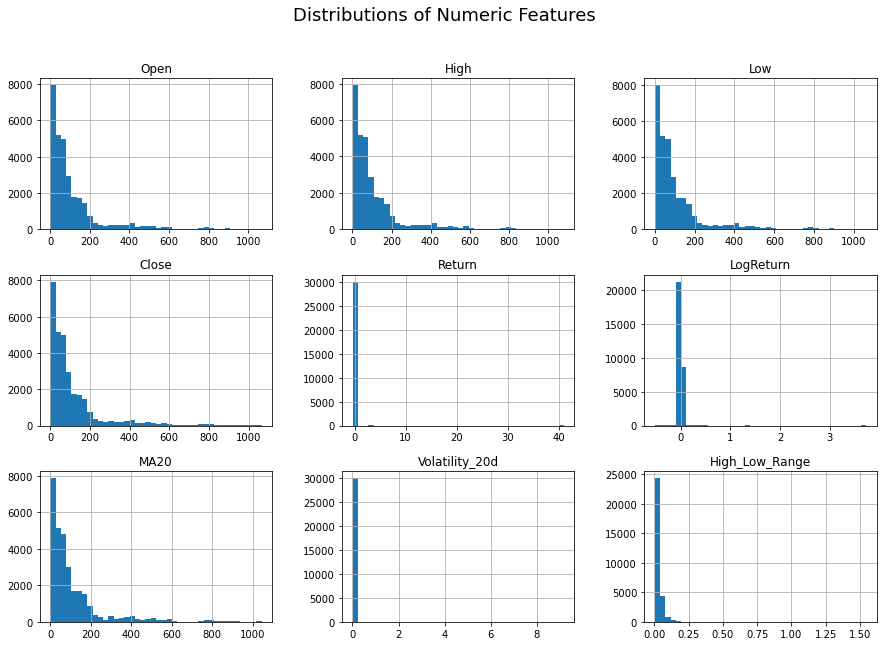

In [20]:
df_2024[numeric_cols].hist(figsize=(15,10), bins=40)
plt.suptitle('Distributions of Numeric Features', fontsize=18)
plt.savefig("distributions_numeric_features.png", dpi=300, bbox_inches='tight')
plt.show()

Correlation Matrix

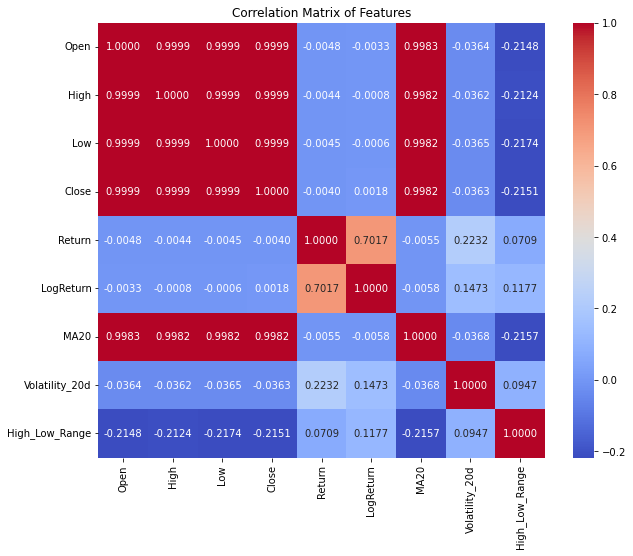

In [21]:
corr = df_2024[numeric_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.4f', cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.savefig("correlationMatrix.png", dpi=300, bbox_inches='tight')
plt.show()

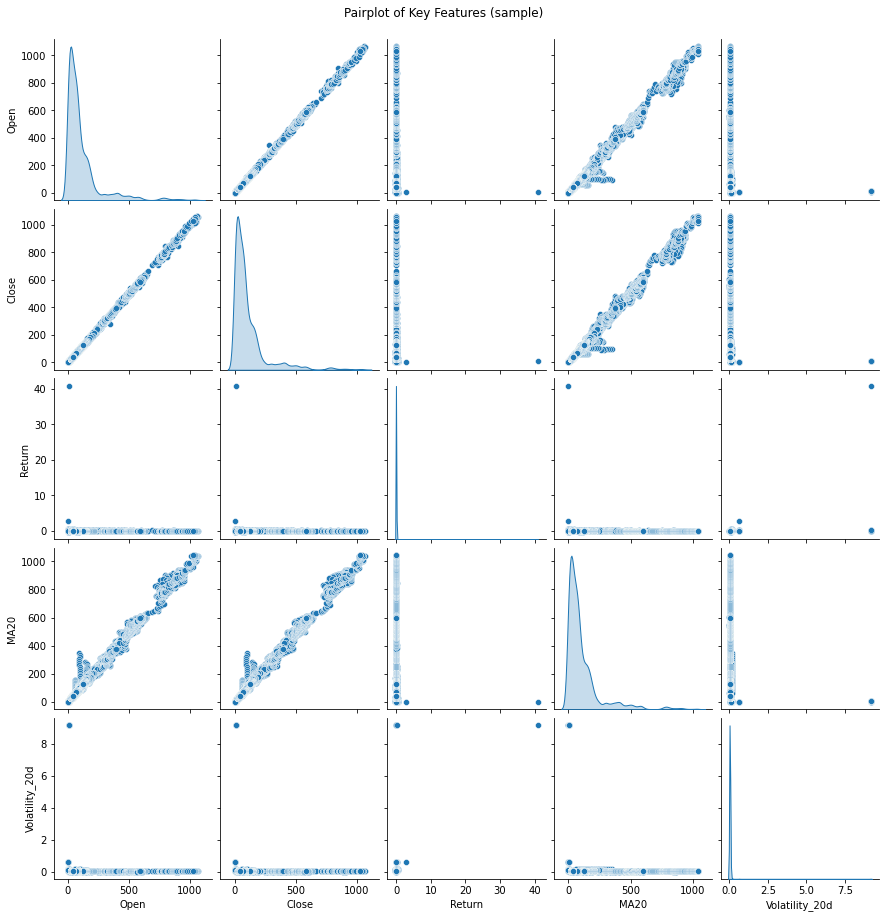

In [22]:
sns.pairplot(df_2024[['Open', 'Close', 'Return', 'MA20', 'Volatility_20d']], diag_kind='kde')
plt.suptitle('Pairplot of Key Features (sample)', y=1.02)
plt.savefig("pairplotKeyFeatures.png", dpi=300, bbox_inches='tight')
plt.show()

In [23]:
# By Sector (Industry)
industry_stats = df_2024.groupby('Sector')[numeric_cols].agg(['mean', 'std', 'min', 'max', 'median', 'count'])
print("Industry Summary Stats:\n", industry_stats)

Industry Summary Stats:
                               Open                                        \
                              mean         std      min      max  median   
Sector                                                                     
Communication Services   84.682898  135.873432   0.1628   631.50  43.335   
Consumer Discretionary  105.340467   96.643655   1.5600   475.90  76.060   
Consumer Staples         69.148354   48.390348   5.3300   219.97  71.900   
Energy                   68.901213   53.087237   6.6600   181.77  41.310   
Financials              198.126984  239.240324  13.3200  1068.19  97.815   
Helathcare              217.490279  256.695391   0.1951   957.77  91.740   
Industrials             109.046404  112.872065   1.6400   466.00  66.970   
Materials                86.991860  103.408564   0.2043   399.76  45.300   
Real Estate              72.196128   51.016312   9.9800   184.72  59.765   
Tech                    108.587916  113.581155  10.6700   467.0

Features by Sector

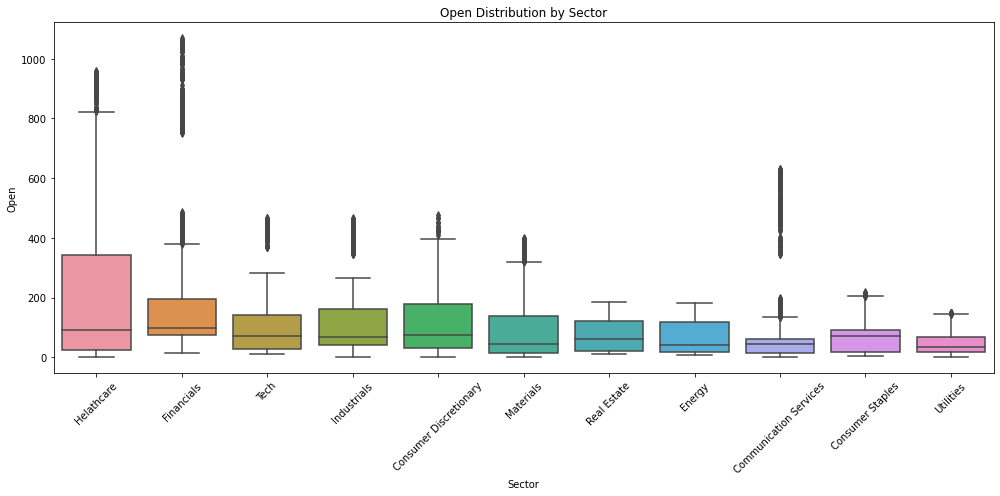

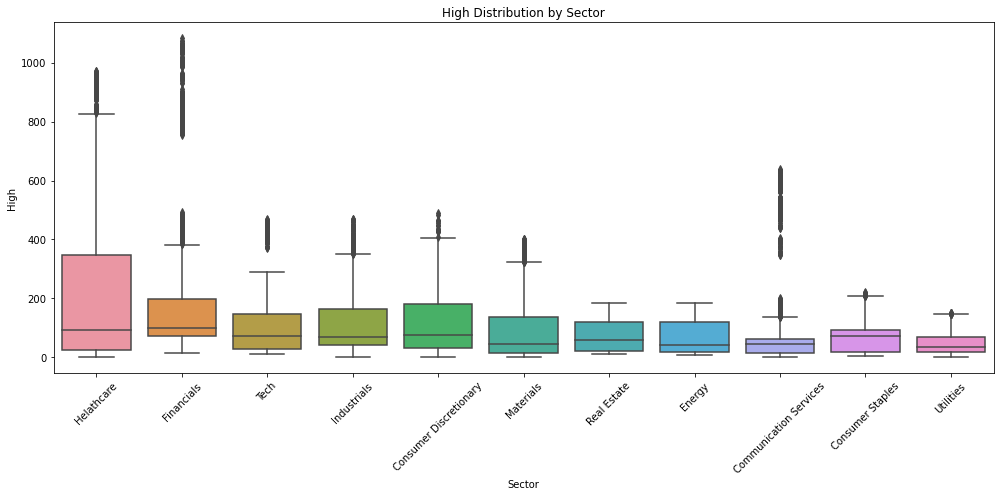

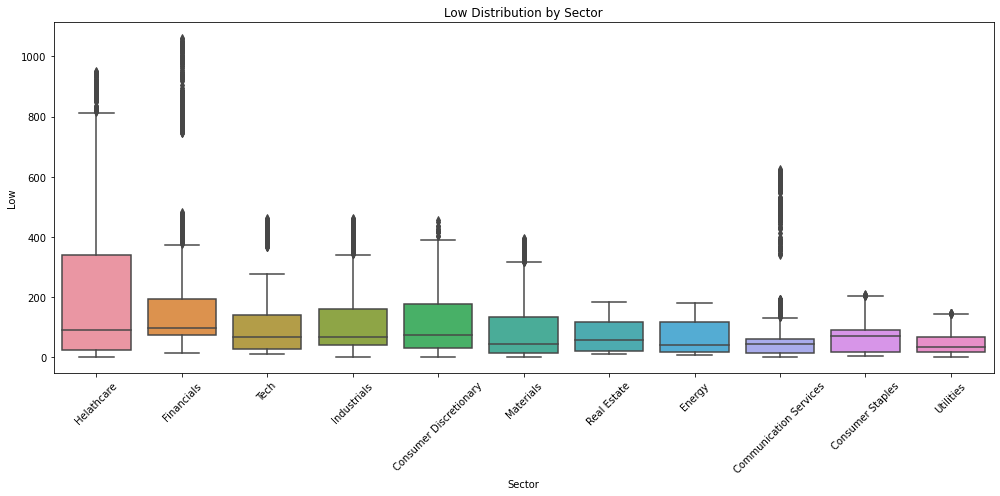

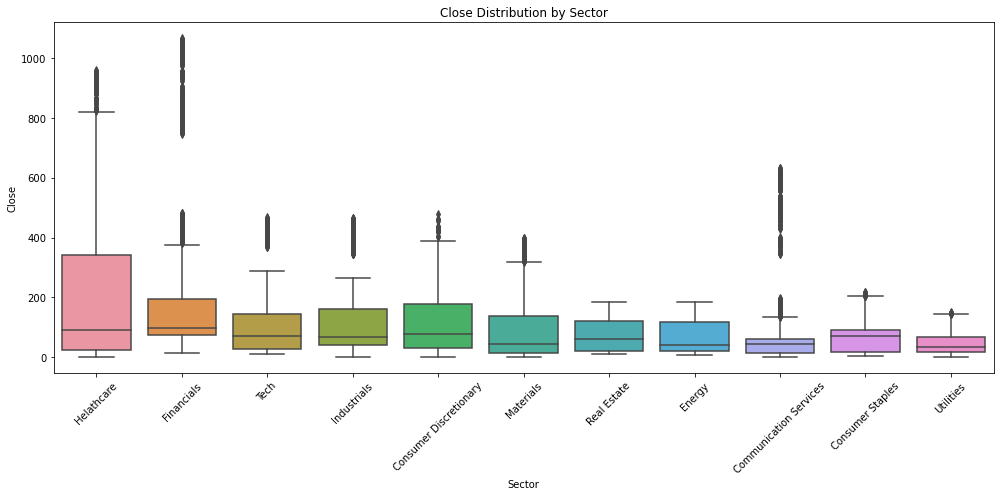

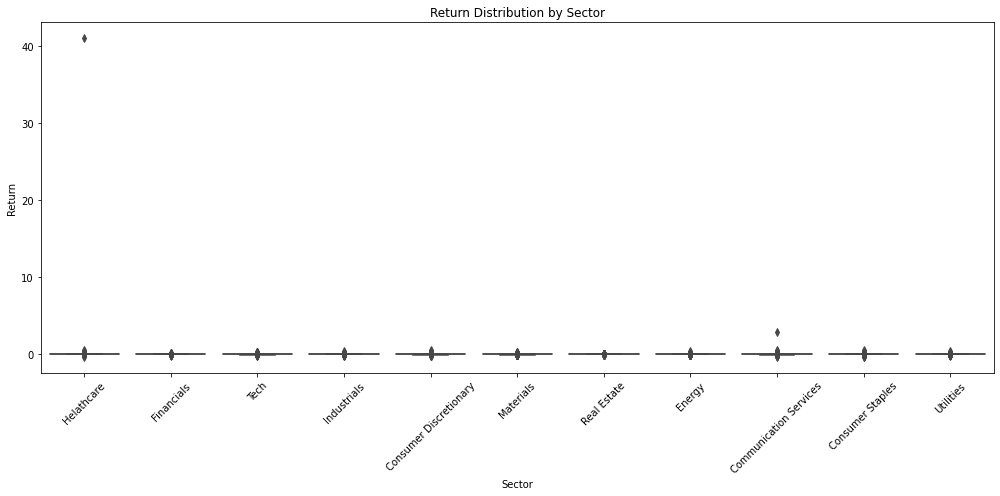

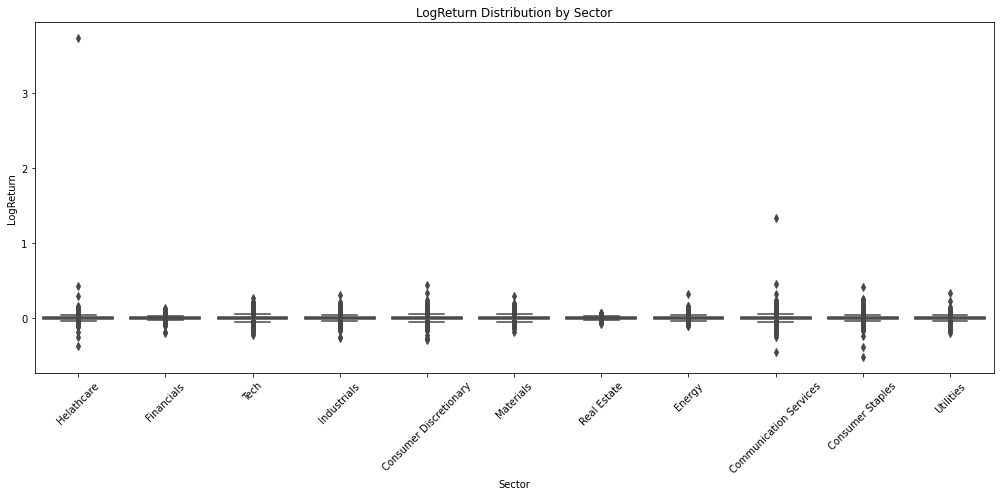

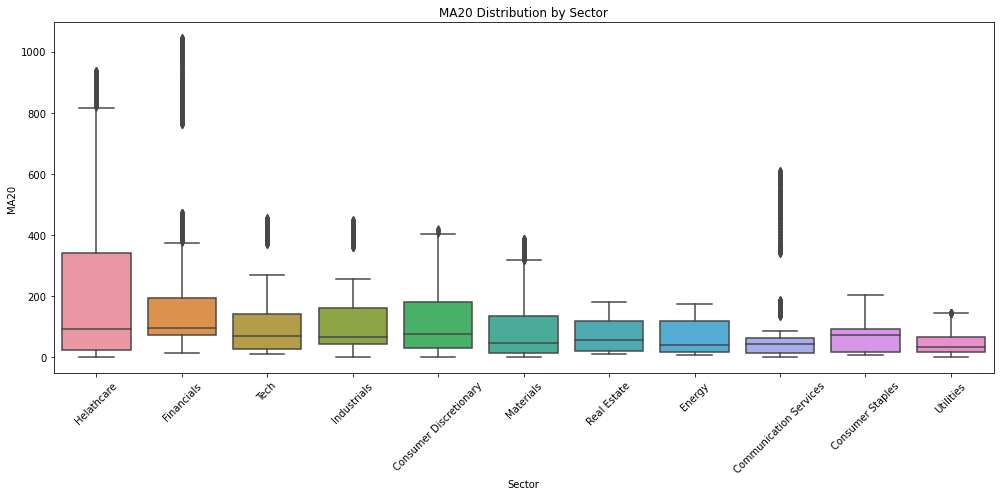

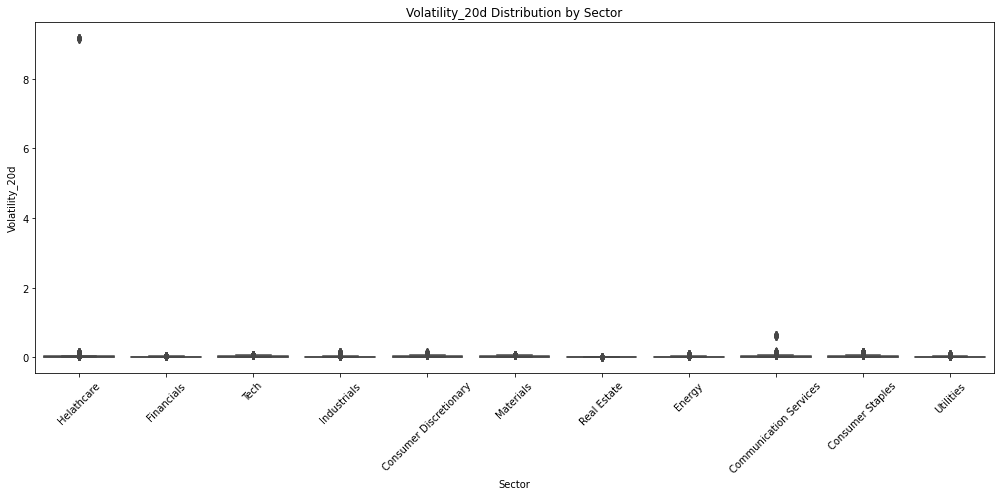

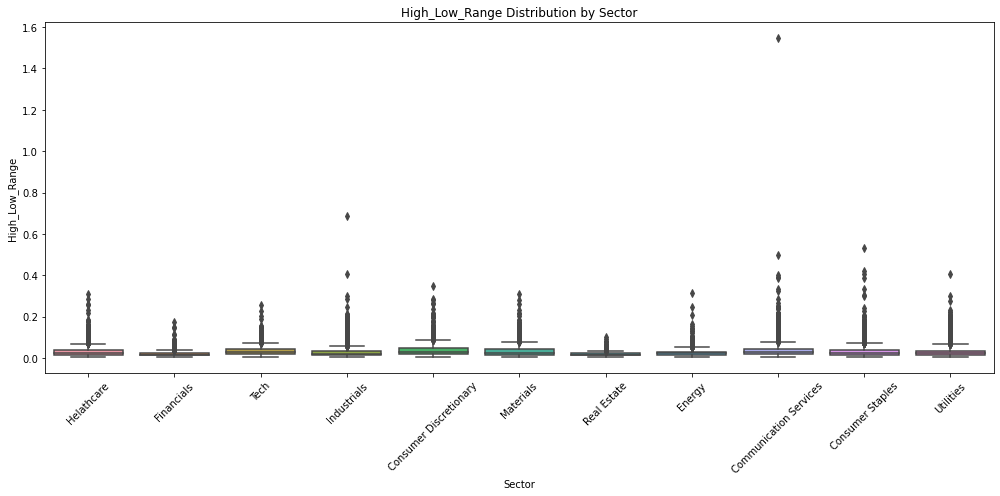

In [24]:
for col in numeric_cols:
    plt.figure(figsize=(14, 7))
    sns.boxplot(data=df_2024, x='Sector', y=col)
    plt.xticks(rotation=45)
    plt.title(f'{col} Distribution by Sector')
    plt.tight_layout()
    plt.savefig(f"{col}BySector.png", dpi=300, bbox_inches='tight')
    plt.show()

# Clustering

Preparing data for clusters

In [25]:
# Remove STRA drop (found when investigating big drop)
suspicious_dates = pd.to_datetime([
    '2024-08-21', '2024-08-22', '2024-08-23', '2024-08-26', '2024-08-27',
    '2024-08-28', '2024-08-29', '2024-08-30', '2024-09-03', '2024-09-04',
    '2024-09-05', '2024-09-06', '2024-09-09', '2024-09-10', '2024-09-11',
    '2024-09-12', '2024-09-13', '2024-09-16', '2024-09-17', '2024-09-18'
])

df_2024 = df_2024[~((df_2024['Ticker'] == 'STRA') & (df_2024['Date'].isin(suspicious_dates)))]
clust_df = df_2024[df_2024['Ticker'] != 'SPY'].copy()
clust_df = pd.get_dummies(clust_df, columns=['Sector', 'MarketCap'], drop_first=False)

features = [col for col in clust_df.columns if col not in ['Date', 'Ticker']]
agg_df = clust_df.sort_values(by='Ticker').dropna(subset=features)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(agg_df[features])

### K-Means

In [26]:
results = []
inertias = []

inits = ['k-means++', 'random']
n_init_values = [10, 20]

for k in range(2, 13):
    for init in inits:
        for n_init in n_init_values:
            kmeans = KMeans(n_clusters=k, init=init, n_init=n_init, random_state=42)
            labels = kmeans.fit_predict(X_scaled)
            
            silhouette = silhouette_score(X_scaled, labels)
            davies = davies_bouldin_score(X_scaled, labels)
            calinski = calinski_harabasz_score(X_scaled, labels)
            inertia = kmeans.inertia_
            
            results.append({
                'No. of Clusters': k,
                'Init Method': init,
                'n_init': n_init,
                'Silhouette': round(silhouette, 4),
                'Davies-Bouldin': round(davies, 4),
                'Calinski-Harabasz': round(calinski, 4),
                'Inertia': round(inertia, 2)
            })

results_df = pd.DataFrame(results)
print(results_df.sort_values('Silhouette', ascending=False).head(10))

    No. of Clusters Init Method  n_init  Silhouette  Davies-Bouldin  \
43               12      random      20      0.4427          1.0621   
42               12      random      10      0.4427          1.0621   
41               12   k-means++      20      0.4112          1.2145   
40               12   k-means++      10      0.4112          1.2145   
35               10      random      20      0.3748          1.4581   
33               10   k-means++      20      0.3422          1.5028   
32               10   k-means++      10      0.3422          1.5028   
1                 2   k-means++      20      0.3340          1.2327   
0                 2   k-means++      10      0.3340          1.2327   
2                 2      random      10      0.3340          1.2327   

    Calinski-Harabasz    Inertia  
43          3920.8216  292438.25  
42          3920.8216  292438.25  
41          4297.4715  276718.67  
40          4297.4715  276718.67  
35          3504.4226  347697.54  
33      

### SOM

In [27]:
som_results = []
grid_sizes = range(2, 13)
sigmas = [0.3, 0.7, 1.0]
learning_rates = [0.1, 0.3, 0.5]

for k in grid_sizes:
    for sigma in sigmas:
        for lr in learning_rates:
            som = MiniSom(x=k, y=1, input_len=X_scaled.shape[1], sigma=sigma, learning_rate=lr, random_seed=42)
            som.random_weights_init(X_scaled)
            som.train_batch(X_scaled, num_iteration=1000)

            labels = np.array([som.winner(xi)[0] for xi in X_scaled])
            cluster_ids = np.array(labels)

            silhouette = silhouette_score(X_scaled, cluster_ids)
            davies = davies_bouldin_score(X_scaled, cluster_ids)
            calinski = calinski_harabasz_score(X_scaled, cluster_ids)

            som_results.append({
                'No. of Clusters': k,
                'Sigma': sigma,
                'Learning Rate': lr,
                'Silhouette': round(silhouette, 4),
                'Davies-Bouldin': round(davies, 4),
                'Calinski-Harabasz': round(calinski, 4)
            })

som_df = pd.DataFrame(som_results)
print(som_df.sort_values('Silhouette', ascending=False).head(10))

    No. of Clusters  Sigma  Learning Rate  Silhouette  Davies-Bouldin  \
2                 2    0.3            0.5      0.4311          1.1057   
11                3    0.3            0.5      0.2978          1.4941   
1                 2    0.3            0.3      0.2694          1.7455   
90               12    0.3            0.1      0.2561          1.8851   
0                 2    0.3            0.1      0.2500          1.8175   
10                3    0.3            0.3      0.2498          1.7544   
83               11    0.3            0.5      0.2325          1.8156   
9                 3    0.3            0.1      0.2304          1.7883   
81               11    0.3            0.1      0.2287          1.8575   
82               11    0.3            0.3      0.2225          1.8516   

    Calinski-Harabasz  
2            681.6630  
11           703.2981  
1           4549.7137  
90          2365.9343  
0           4534.2763  
10          2718.7375  
83          1587.9932  
9   

### Fuzzy C-Means

In [28]:
fcm_results = []
fuzziness_values = [1.5, 2.0, 2.5]

for k in range(2, 13):
    for m in fuzziness_values:
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
            X_scaled.T, c=k, m=m, error=0.005, maxiter=1000, init=None, seed=42
        )
        labels = np.argmax(u, axis=0)

        silhouette = silhouette_score(X_scaled, labels)
        davies = davies_bouldin_score(X_scaled, labels)
        calinski = calinski_harabasz_score(X_scaled, labels)

        fcm_results.append({
            'No. of Clusters': k,
            'Fuzziness m': m,
            'Silhouette': round(silhouette, 4),
            'Davies-Bouldin': round(davies, 4),
            'Calinski-Harabasz': round(calinski, 4),
            'FPC': round(fpc, 4)
        })

fcm_df = pd.DataFrame(fcm_results)
print(fcm_df.sort_values('Silhouette', ascending=False).head(10))

    No. of Clusters  Fuzziness m  Silhouette  Davies-Bouldin  \
0                 2          1.5      0.1274          2.4915   
1                 2          2.0      0.1274          2.4916   
2                 2          2.5      0.1271          2.4929   
4                 3          2.0      0.0330          2.6317   
5                 3          2.5      0.0285          2.6798   
3                 3          1.5     -0.0105          3.0761   
6                 4          1.5     -0.0332          4.8076   
8                 4          2.5     -0.0343          2.6919   
9                 5          1.5     -0.0375          7.1110   
12                6          1.5     -0.0489          8.4689   

    Calinski-Harabasz     FPC  
0           3937.8021  0.5000  
1           3936.6009  0.5000  
2           3931.2193  0.5000  
4           1978.3269  0.3333  
5           1990.7814  0.3333  
3           1974.4610  0.3333  
6           1318.2497  0.2500  
8           1486.7384  0.2500  
9      

In [29]:
import pandas as pd
from IPython.display import display, HTML

results_df['No. of Clusters'] = results_df['No. of Clusters'].astype(int)
som_df['No. of Clusters'] = som_df['No. of Clusters'].astype(int)
fcm_df['No. of Clusters'] = fcm_df['No. of Clusters'].astype(int)

def format_transposed_table(df, extra_cols=[]):
    df = df[df['No. of Clusters'] <= 12].copy()
    df = df.sort_values('Silhouette', ascending=False).drop_duplicates('No. of Clusters')
    df = df.sort_values('No. of Clusters')
    df = df.set_index('No. of Clusters')
    all_cols = ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz'] + extra_cols + ['Config']
    return df[all_cols].T

def highlight_best_transposed(df):
    silhouette = pd.to_numeric(df.loc['Silhouette'], errors='coerce')
    k_ge_3 = silhouette[silhouette.index >= 3]
    if not k_ge_3.empty:
        best_k = k_ge_3.idxmax()
        return df.style.apply(lambda col: ['font-weight: bold' if col.name == best_k else '' for _ in col], axis=0)
    return df.style


# KMeans Table
kmeans_best = results_df.copy()
kmeans_best['Config'] = kmeans_best['Init Method']
kmeans_t = format_transposed_table(kmeans_best)
print("🔹 KMeans (Best Config per k)")
display(highlight_best_transposed(kmeans_t))

# SOM Table
som_best = som_df.copy()
som_best['Config'] = som_best.apply(lambda row: f"σ={row['Sigma']}, lr={row['Learning Rate']}", axis=1)
som_t = format_transposed_table(som_best)
print("🔹 SOM (Best Config per k)")
display(highlight_best_transposed(som_t))

# FCM Table
fcm_best = fcm_df.copy()
fcm_best['Config'] = fcm_best.apply(lambda row: f"m={row['Fuzziness m']}", axis=1)
fcm_t = format_transposed_table(fcm_best)
print("🔹 Fuzzy C-Means (Best Config per k)")
display(highlight_best_transposed(fcm_t))

🔹 KMeans (Best Config per k)


No. of Clusters,2,3,4,5,6,7,8,9,10,11,12
Silhouette,0.334000,0.136200,0.163800,0.189800,0.187700,0.239700,0.242400,0.259400,0.374800,0.333000,0.442700
Davies-Bouldin,1.232700,2.171400,1.957800,1.818400,1.630300,1.683500,1.479000,1.517400,1.458100,1.269900,1.062100
Calinski-Harabasz,5456.680400,4578.029800,4175.503300,3673.346700,3531.336600,3284.316500,3558.592600,3393.151300,3504.422600,3887.416600,3920.821600
Config,k-means++,k-means++,random,k-means++,random,random,k-means++,k-means++,random,k-means++,random


🔹 SOM (Best Config per k)


No. of Clusters,2,3,4,5,6,7,8,9,10,11,12
Silhouette,0.431100,0.297800,0.103100,0.114300,0.126800,0.166200,0.181600,0.152200,0.164800,0.232500,0.256100
Davies-Bouldin,1.105700,1.494100,2.590800,2.360500,2.062300,2.100700,2.202100,2.104700,1.973400,1.815600,1.885100
Calinski-Harabasz,681.663000,703.298100,2545.714800,2001.261300,2442.110700,2518.577900,1791.198600,1445.078200,1675.533100,1587.993200,2365.934300
Config,"σ=0.3, lr=0.5","σ=0.3, lr=0.5","σ=0.3, lr=0.3","σ=0.3, lr=0.3","σ=0.3, lr=0.5","σ=0.3, lr=0.1","σ=0.3, lr=0.3","σ=0.3, lr=0.1","σ=0.7, lr=0.1","σ=0.3, lr=0.5","σ=0.3, lr=0.1"


🔹 Fuzzy C-Means (Best Config per k)


No. of Clusters,2,3,4,5,6,7,8,9,10,11,12
Silhouette,0.127400,0.033000,-0.033200,-0.037500,-0.048900,-0.053100,-0.055500,-0.057700,-0.122700,-0.127100,-0.138800
Davies-Bouldin,2.491500,2.631700,4.807600,7.111000,8.468900,7.542900,9.893200,8.728000,7.290400,6.395800,7.176300
Calinski-Harabasz,3937.802100,1978.326900,1318.249700,991.123200,795.141100,663.870700,569.345600,498.868500,444.086400,445.262200,446.937300
Config,m=1.5,m=2.0,m=1.5,m=1.5,m=1.5,m=1.5,m=1.5,m=1.5,m=1.5,m=1.5,m=1.5


Fit Best Models

In [30]:
# Best KMeans
k_kmeans = 12
kmeans = KMeans(n_clusters=k_kmeans, init='random', random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Best SOM
k_som = 3  
som_sigma = 0.3
som_lr = 0.5
som = MiniSom(x=k_som, y=1, input_len=X_scaled.shape[1], sigma=som_sigma, learning_rate=som_lr, random_seed=42)
som.random_weights_init(X_scaled)
som.train_batch(X_scaled, num_iteration=1000)
som_labels = np.array([som.winner(xi)[0] for xi in X_scaled])

# Best Fuzzy C-Means Config
k_fcm = 3
fcm_m = 2.0
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_scaled.T, c=k_fcm, m=fcm_m, error=0.005, maxiter=1000, init=None, seed=42
)
fcm_labels = np.argmax(u, axis=0)

# Attach labels to full DataFrame
clustered_df = clust_df.copy()
clustered_df['KMeans_Cluster'] = kmeans_labels
clustered_df['SOM_Cluster'] = som_labels
clustered_df['FuzzyCMeans_Cluster'] = fcm_labels

df_2024_clusters = df_2024.copy()
df_2024_clusters['Ticker'] = df_2024_clusters['Ticker'].astype(str)
df_2024_clusters['Date'] = pd.to_datetime(df_2024_clusters['Date'])

clustered_df['Ticker'] = clustered_df['Ticker'].astype(str)
clustered_df['Date'] = pd.to_datetime(clustered_df['Date'])

df_2024_clusters = df_2024_clusters.merge(
    clustered_df[['Date', 'Ticker', 'KMeans_Cluster', 'SOM_Cluster', 'FuzzyCMeans_Cluster']],
    on=['Date', 'Ticker'],
    how='left'
)

df_2024_clusters

,Date,Open,High,Low,Close,5. volume,Ticker,Sector,MarketCap,Return,LogReturn,MA20,Volatility_20d,High_Low_Range,KMeans_Cluster,SOM_Cluster,FuzzyCMeans_Cluster
0,2024-01-02,580.410,592.7200,579.0500,592.20,3226661,LLY,Helathcare,Large,0.015920,0.015794,582.0865,0.014549,0.023552,4.0,1.0,0.0
1,2024-01-03,600.000,619.8400,598.8000,617.70,5130330,LLY,Helathcare,Large,0.043060,0.042158,583.6875,0.017356,0.035067,4.0,1.0,0.0
2,2024-01-04,625.260,636.4100,613.2700,614.50,6272532,LLY,Helathcare,Large,-0.005181,-0.005194,585.0050,0.017442,0.037009,4.0,1.0,0.0
3,2024-01-05,614.000,619.9400,610.1900,618.55,2216795,LLY,Helathcare,Large,0.006591,0.006569,586.4700,0.017468,0.015879,4.0,1.0,0.0
4,2024-01-08,622.430,626.0599,609.5900,626.03,2453931,LLY,Helathcare,Large,0.012093,0.012020,588.3580,0.017563,0.026461,4.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30064,2024-12-24,596.060,601.3400,595.4700,601.30,33160097,SPY,NaN,Large,0.011115,0.011054,601.2890,0.008586,0.009848,NaN,NaN,NaN
30065,2024-12-26,599.500,602.4800,598.0825,601.34,41338891,SPY,NaN,Large,0.000067,0.000067,601.3235,0.008509,0.007335,NaN,NaN,NaN
30066,2024-12-27,597.540,597.7761,590.7647,595.01,64969310,SPY,NaN,Large,-0.010526,-0.010582,601.1325,0.008813,0.011734,NaN,NaN,NaN
30067,2024-12-30,587.890,591.7400,584.4100,588.22,56578757,SPY,NaN,Large,-0.011412,-0.011477,600.4160,0.009009,0.012468,NaN,NaN,NaN


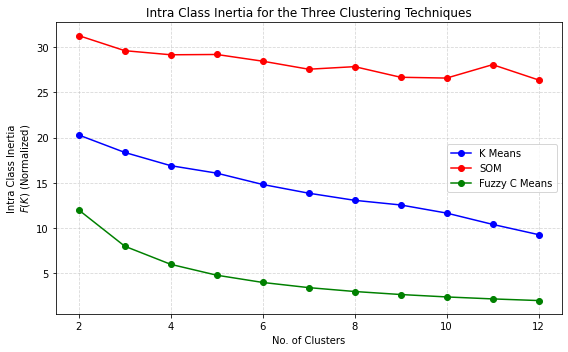

In [31]:
ks = list(range(2, 13))
n_samples = X_scaled.shape[0]

kmeans_inertia_list = []
som_inertia_list = []
fcm_inertia_list = []

for k in ks:
    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    kmeans_inertia_list.append(kmeans.inertia_ / n_samples)  # normalized

    # SOM
    som = MiniSom(x=k, y=1, input_len=X_scaled.shape[1], sigma=1.0, learning_rate=0.5, random_seed=42)
    som.random_weights_init(X_scaled)
    som.train_batch(X_scaled, num_iteration=1000)
    som_labels = np.array([som.winner(xi)[0] for xi in X_scaled])
    som_centroids = np.array([som.get_weights()[i, 0] for i in range(k)])
    som_ss = np.sum([np.linalg.norm(X_scaled[i] - som_centroids[som_labels[i]])**2 for i in range(n_samples)])
    som_inertia_list.append(som_ss / n_samples)

    # Fuzzy C-means
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X_scaled.T, c=k, m=2, error=0.005, maxiter=1000, init=None, seed=42
    )
    fcm_inertia_list.append(jm[-1] / n_samples)  # normalized

# Plot
plt.figure(figsize=(8, 5))
plt.plot(ks, kmeans_inertia_list, marker='o', label='K Means', color='blue')
plt.plot(ks, som_inertia_list, marker='o', label='SOM', color='red')
plt.plot(ks, fcm_inertia_list, marker='o', label='Fuzzy C Means', color='green')
plt.xlabel('No. of Clusters')
plt.ylabel('Intra Class Inertia\n$F(K)$ (Normalized)')
plt.title('Intra Class Inertia for the Three Clustering Techniques')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("IntraclassInertia.png", dpi=300, bbox_inches='tight')
plt.show()

Portfolio Builder

In [32]:
# Filtering tickers
returns_wide = df_2024_clusters.pivot(index='Date', columns='Ticker', values='Return')
valid_tickers = returns_wide.columns[returns_wide.notna().sum() >= 30].tolist()

filter_pre_2008 = True  # Toggle this to False to allow all tickers

if filter_pre_2008:
    tickers_pre_2008 = main_df[main_df['Date'] < '2008-01-01']['Ticker'].unique()
    valid_tickers_filtered = [t for t in valid_tickers if t in tickers_pre_2008]
else:
    valid_tickers_filtered = valid_tickers


# Portfolio Builder (Three methods: top close price, top average return, lowest volatility)
def build_portfolio(df, cluster_col, metric, ascending, valid_tickers, per_cluster_max=3, min_total=10):
    cluster_map = df.groupby('Ticker')[cluster_col].last().dropna()
    portfolio, cluster_contributions = [], {}
    for cluster in sorted(cluster_map.unique()):
        tickers = [t for t in cluster_map[cluster_map == cluster].index if t in valid_tickers]
        if tickers:
            metric_vals = df[df['Ticker'].isin(tickers)].groupby('Ticker')[metric].mean().dropna()
            ranked = metric_vals.sort_values(ascending=ascending).index.tolist()
            top = ranked[:per_cluster_max]
            portfolio.extend(top)
            cluster_contributions[cluster] = ranked
    portfolio = list(dict.fromkeys(portfolio))
    for cluster in cluster_contributions:
        for t in cluster_contributions[cluster]:
            if len(portfolio) >= min_total:
                break
            if t not in portfolio:
                portfolio.append(t)
    return portfolio

# Return Portfolio Builder
def build_return_portfolio(df, cluster_col, valid_tickers, min_total=10):
    cluster_map = df.groupby('Ticker')[cluster_col].last().dropna()
    portfolio, cluster_contributions = [], {}
    for cluster in sorted(cluster_map.unique()):
        tickers = [t for t in cluster_map[cluster_map == cluster].index if t in valid_tickers]
        subset = df[df['Ticker'].isin(tickers)]
        stable = subset.groupby('Ticker')['Return'].apply(lambda r: r.abs().max() < 0.2)
        tickers = stable[stable].index.tolist()
        stats = subset[subset['Ticker'].isin(tickers)].groupby('Ticker')['Return'].agg(['count', 'mean', 'std'])
        filtered = stats[(stats['count'] >= 30) & (stats['std'] >= 0.0005)]
        ranked = filtered.sort_values('mean', ascending=False).index.tolist()
        top = ranked[:3]
        portfolio.extend(top)
        cluster_contributions[cluster] = ranked
    portfolio = list(dict.fromkeys(portfolio))
    for cluster in cluster_contributions:
        for t in cluster_contributions[cluster]:
            if len(portfolio) >= min_total:
                break
            if t not in portfolio:
                portfolio.append(t)
    return portfolio

# Build All Portfolios
portfolio_kmeans_close = build_portfolio(df_2024_clusters, 'KMeans_Cluster', 'Close', False, valid_tickers_filtered)
portfolio_som_close = build_portfolio(df_2024_clusters, 'SOM_Cluster', 'Close', False, valid_tickers_filtered)
portfolio_fcm_close = build_portfolio(df_2024_clusters, 'FuzzyCMeans_Cluster', 'Close', False, valid_tickers_filtered)

portfolio_kmeans_return = build_return_portfolio(df_2024_clusters, 'KMeans_Cluster', valid_tickers_filtered)
portfolio_som_return = build_return_portfolio(df_2024_clusters, 'SOM_Cluster', valid_tickers_filtered)
portfolio_fcm_return = build_return_portfolio(df_2024_clusters, 'FuzzyCMeans_Cluster', valid_tickers_filtered)

portfolio_kmeans_vol = build_portfolio(df_2024_clusters, 'KMeans_Cluster', 'Volatility_20d', True, valid_tickers_filtered)
portfolio_som_vol = build_portfolio(df_2024_clusters, 'SOM_Cluster', 'Volatility_20d', True, valid_tickers_filtered)
portfolio_fcm_vol = build_portfolio(df_2024_clusters, 'FuzzyCMeans_Cluster', 'Volatility_20d', True, valid_tickers_filtered)

# Format for Display
def make_portfolio_table(portfolio, method, cluster):
    w = 1 / len(portfolio) if portfolio else 0
    return pd.DataFrame({
        'Portfolio': [f"{method} - {cluster}"] * len(portfolio),
        'Company': portfolio,
        'Weight': [w] * len(portfolio)
    })

portfolio_table_all = pd.concat([
    make_portfolio_table(portfolio_kmeans_close, "Top Close", "KMeans"),
    make_portfolio_table(portfolio_som_close, "Top Close", "SOM"),
    make_portfolio_table(portfolio_fcm_close, "Top Close", "Fuzzy C-Means"),
    make_portfolio_table(portfolio_kmeans_return, "Top Return", "KMeans"),
    make_portfolio_table(portfolio_som_return, "Top Return", "SOM"),
    make_portfolio_table(portfolio_fcm_return, "Top Return", "Fuzzy C-Means"),
    make_portfolio_table(portfolio_kmeans_vol, "Low Volatility", "KMeans"),
    make_portfolio_table(portfolio_som_vol, "Low Volatility", "SOM"),
    make_portfolio_table(portfolio_fcm_vol, "Low Volatility", "Fuzzy C-Means")
], ignore_index=True)

# Cumulative Return Computation
def compute_cumulative_returns(df, tickers, label, full_dates=None, latest_start='2024-01-31'):
    df = df[df['Ticker'].isin(tickers)]
    r = df.pivot(index='Date', columns='Ticker', values='Return')
    r = r.loc[:, r.notna().sum() >= 30]
    valid_start = pd.to_datetime(latest_start)
    keep = [col for col in r if r[col].first_valid_index() and r[col].first_valid_index() <= valid_start]
    r = r[keep]
    if full_dates is not None:
        r = r.reindex(full_dates)
    r = r.ffill().fillna(0)
    if r.empty:
        return pd.Series(dtype='float64', name=label)
    weights = np.ones(len(r.columns)) / len(r.columns)
    daily_returns = r.dot(weights)
    return (1 + daily_returns).cumprod().rename(label)

# Build Cumulative Return Dictionary
cumulative_returns_dict = {
    'KMeans (Close)': compute_cumulative_returns(df_2024_clusters, portfolio_kmeans_close, 'KMeans (Close)'),
    'SOM (Close)': compute_cumulative_returns(df_2024_clusters, portfolio_som_close, 'SOM (Close)'),
    'FCM (Close)': compute_cumulative_returns(df_2024_clusters, portfolio_fcm_close, 'FCM (Close)'),
    'KMeans (Return)': compute_cumulative_returns(df_2024_clusters, portfolio_kmeans_return, 'KMeans (Return)'),
    'SOM (Return)': compute_cumulative_returns(df_2024_clusters, portfolio_som_return, 'SOM (Return)'),
    'FCM (Return)': compute_cumulative_returns(df_2024_clusters, portfolio_fcm_return, 'FCM (Return)'),
    'KMeans (Low Vol)': compute_cumulative_returns(df_2024_clusters, portfolio_kmeans_vol, 'KMeans (Low Vol)'),
    'SOM (Low Vol)': compute_cumulative_returns(df_2024_clusters, portfolio_som_vol, 'SOM (Low Vol)'),
    'FCM (Low Vol)': compute_cumulative_returns(df_2024_clusters, portfolio_fcm_vol, 'FCM (Low Vol)')
}

Stocks for each method

In [33]:
strategy_labels = ['Top Close', 'Top Return', 'Low Volatility']
method_labels = ['KMeans', 'SOM', 'Fuzzy C-Means']

concise_data = []
for strategy in strategy_labels:
    row = []
    for method in method_labels:
        if strategy == 'Top Close':
            tickers = {
                'KMeans': portfolio_kmeans_close,
                'SOM': portfolio_som_close,
                'Fuzzy C-Means': portfolio_fcm_close
            }[method]
        elif strategy == 'Top Return':
            tickers = {
                'KMeans': portfolio_kmeans_return,
                'SOM': portfolio_som_return,
                'Fuzzy C-Means': portfolio_fcm_return
            }[method]
        else:  # Low Volatility
            tickers = {
                'KMeans': portfolio_kmeans_vol,
                'SOM': portfolio_som_vol,
                'Fuzzy C-Means': portfolio_fcm_vol
            }[method]
        row.append(", ".join(tickers))
    concise_data.append(row)


concise_ticker_table = pd.DataFrame(concise_data, index=strategy_labels, columns=method_labels)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

display(concise_ticker_table)

,KMeans,SOM,Fuzzy C-Means
Top Close,"SHW, GE, X, ALL, NKE, SYY, SPG, AXS, REX, JNJ, LAMR, STT, LLY, CI, XOM, MSFT, WELL, NRP, MCD, AMZN, SIGI, BRK.B, DE, CLH, AAPL, GOOGL, AFL, BLK, UNH, JPM, WSM, SLAB, AOS, KWR, MAA, ON","BLK, LLY, UNH, ASA, BRK.B, MSFT, DE, SHW, CI, MCD","BLK, LLY, UNH, BRK.B, MSFT, SHW, DE, AMZN, KWR, SPG"
Top Return,"SHW, HMC, X, ALL, GCO, ASA, AXS, SPG, CSIQ, BAC, STT, LAMR, WMT, LLY, PSMT, DAL, WELL, BRC, AMZN, MCD, SIGI, CLH, BRK.B, RGLD, GOOGL, AAPL, AFL, JPM, BLK, NYT, FUN, SLAB, AOS, CDE, IMAX, NHI","CDE, IMAX, WMT, ASA, AXS, DAL, AMZN, JPM, WELL, GOOGL","IMAX, WMT, AXS, CDE, JPM, GOOGL, DAL, AMZN, WELL, LLY"
Low Volatility,"SHW, HMC, GE, SYY, ALL, MFA, SPG, AXS, REX, JNJ, STT, LAMR, XOM, CI, PSMT, WELL, MSFT, AVA, MCD, SIGI, AMZN, BRK.B, NGG, DE, KO, AFL, AAPL, BLK, NYT, JPM, AOS, FUN, SLAB, MAA, NHI, CSR","KO, BRK.B, JNJ, ASA, MCD, BLK, WELL, SYY, XOM, MSFT","BLK, WELL, XOM, KO, BRK.B, JNJ, AFL, AVA, LAMR, SPG"


Feature Importance

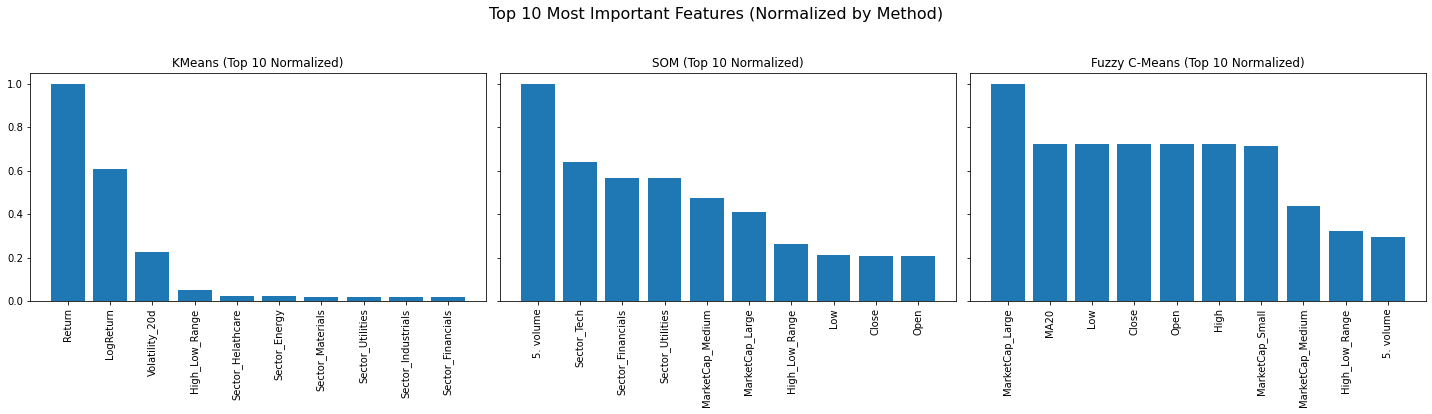

In [34]:
# KMeans
kmeans_imp = np.std(kmeans.cluster_centers_, axis=0)
kmeans_imp_norm = kmeans_imp / np.max(kmeans_imp)
kmeans_feat_imp = pd.Series(kmeans_imp_norm, index=features).sort_values(ascending=False)

# SOM
som_weights = som.get_weights()  # shape: (x, y, features)
som_imp = np.std(som_weights, axis=(0, 1))  # std over neurons
som_imp_norm = som_imp / np.max(som_imp)
som_feat_imp = pd.Series(som_imp_norm, index=features).sort_values(ascending=False)

# Fuzzy C-Means
fcm_imp = np.std(cntr, axis=0)
fcm_imp_norm = fcm_imp / np.max(fcm_imp) if np.max(fcm_imp) != 0 else fcm_imp
fcm_feat_imp = pd.Series(fcm_imp_norm, index=features).sort_values(ascending=False)

# Plot
top_n = 10
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# KMeans Plot
kmeans_top = kmeans_feat_imp.head(top_n)
axes[0].bar(kmeans_top.index, kmeans_top.values)
axes[0].set_title('KMeans (Top 10 Normalized)')
axes[0].tick_params(axis='x', rotation=90)

# SOM Plot
som_top = som_feat_imp.head(top_n)
axes[1].bar(som_top.index, som_top.values)
axes[1].set_title('SOM (Top 10 Normalized)')
axes[1].tick_params(axis='x', rotation=90)

# FCM Plot
fcm_top = fcm_feat_imp.head(top_n)
axes[2].bar(fcm_top.index, fcm_top.values)
axes[2].set_title('Fuzzy C-Means (Top 10 Normalized)')
axes[2].tick_params(axis='x', rotation=90)

fig.suptitle('Top 10 Most Important Features (Normalized by Method)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("FeatureImportance.png", dpi=300, bbox_inches='tight')
plt.show()

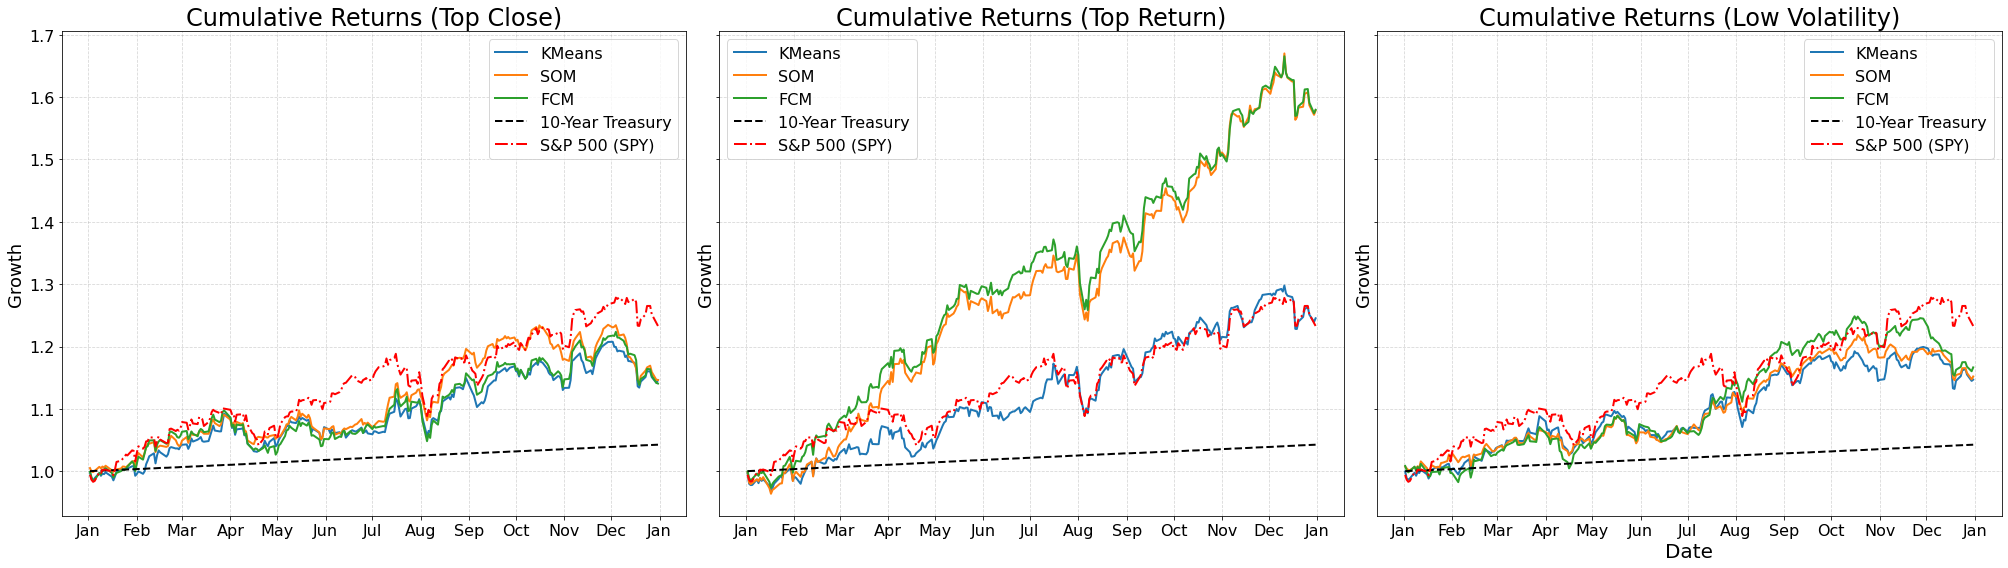

In [35]:
# 10-Year Treasury + SPY for comparison
ten_year_2024 = ten_year_df[ten_year_df['Date'].dt.year == 2024].copy()
ten_year_2024 = ten_year_2024.sort_values('Date')
ten_year_2024['Daily Rate'] = ten_year_2024['10 Yr'] / 100 / 252  # Convert annual % to daily decimal
ten_year_2024['Cumulative'] = (1 + ten_year_2024['Daily Rate']).cumprod()
cum_rf = ten_year_2024.set_index('Date')['Cumulative']

spy_2024 = main_df[(main_df['Ticker'] == 'SPY') & (main_df['Date'].dt.year == 2024)].copy()
spy_2024 = spy_2024.sort_values('Date')
spy_2024 = spy_2024.dropna(subset=['Return'])
spy_2024['Cumulative'] = (1 + spy_2024['Return']).cumprod()
spy_2024_cum = spy_2024.set_index('Date')['Cumulative']

grouped_returns = {
    'Top Close': {
        'KMeans': cumulative_returns_dict['KMeans (Close)'],
        'SOM': cumulative_returns_dict['SOM (Close)'],
        'FCM': cumulative_returns_dict['FCM (Close)']
    },
    'Top Return': {
        'KMeans': cumulative_returns_dict['KMeans (Return)'],
        'SOM': cumulative_returns_dict['SOM (Return)'],
        'FCM': cumulative_returns_dict['FCM (Return)']
    },
    'Low Volatility': {
        'KMeans': cumulative_returns_dict['KMeans (Low Vol)'],
        'SOM': cumulative_returns_dict['SOM (Low Vol)'],
        'FCM': cumulative_returns_dict['FCM (Low Vol)']
    }
}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28, 8), sharey=True)

strategy_colors = {
    'KMeans': 'tab:blue',
    'SOM': 'tab:orange',
    'FCM': 'tab:green'
}

for ax, (strategy_name, cluster_returns) in zip(axes, grouped_returns.items()):
    for cluster_name, series in cluster_returns.items():
        if not series.empty:
            ax.plot(series.index, series.values,
                    label=f"{cluster_name}",
                    color=strategy_colors[cluster_name],
                    linewidth=2)

    if not cum_rf.empty:
        ax.plot(cum_rf.index, cum_rf.values,
                label="10-Year Treasury",
                color="black", linestyle="--", linewidth=2)

    if not spy_2024_cum.empty:
        ax.plot(spy_2024_cum.index, spy_2024_cum.values,
                label="S&P 500 (SPY)",
                color="red", linestyle="-.", linewidth=2)

    ax.set_title(f'Cumulative Returns ({strategy_name})', fontsize=24)
    ax.set_ylabel('Growth', fontsize=18)
    ax.legend(fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(axis='both', labelsize=16)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

axes[-1].set_xlabel('Date', fontsize=20)
plt.tight_layout()
plt.savefig("2024Results.png", dpi=300, bbox_inches='tight')
plt.show()

Sharpe Ratio

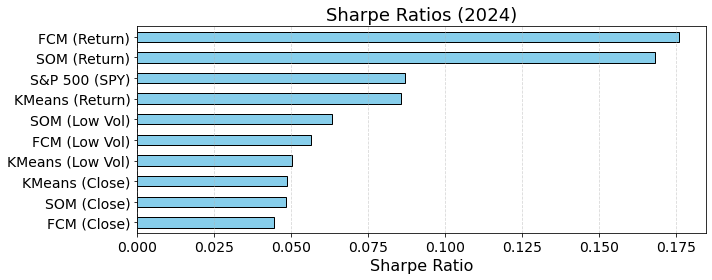

In [36]:
all_curves = cumulative_returns_dict.copy()
all_curves['S&P 500 (SPY)'] = spy_2024_cum
all_curves['10-Year Treasury'] = cum_rf

daily_returns = pd.DataFrame({
    name: series.pct_change()
    for name, series in all_curves.items()
    if not series.empty
}).dropna()

rf = daily_returns['10-Year Treasury']
sharpe_ratios = {}

for name in daily_returns.columns:
    if name != '10-Year Treasury':
        excess = daily_returns[name] - rf
        sharpe_ratios[name] = excess.mean() / excess.std()

sharpe_df = pd.DataFrame.from_dict(sharpe_ratios, orient='index', columns=['Sharpe Ratio'])
sharpe_df = sharpe_df.sort_values(by='Sharpe Ratio', ascending=True)

plt.figure(figsize=(10, 4))
sharpe_df['Sharpe Ratio'].plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Sharpe Ratios (2024)', fontsize=18)
plt.xlabel('Sharpe Ratio', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("2024ResultsSharpe.png", dpi=300, bbox_inches='tight')
plt.show()

sharpe_df_2024 = sharpe_df.copy()

# Stress Test

Tickers removed due to extreme daily returns: ['CREG', 'CYBN', 'KNTK', 'MFA']


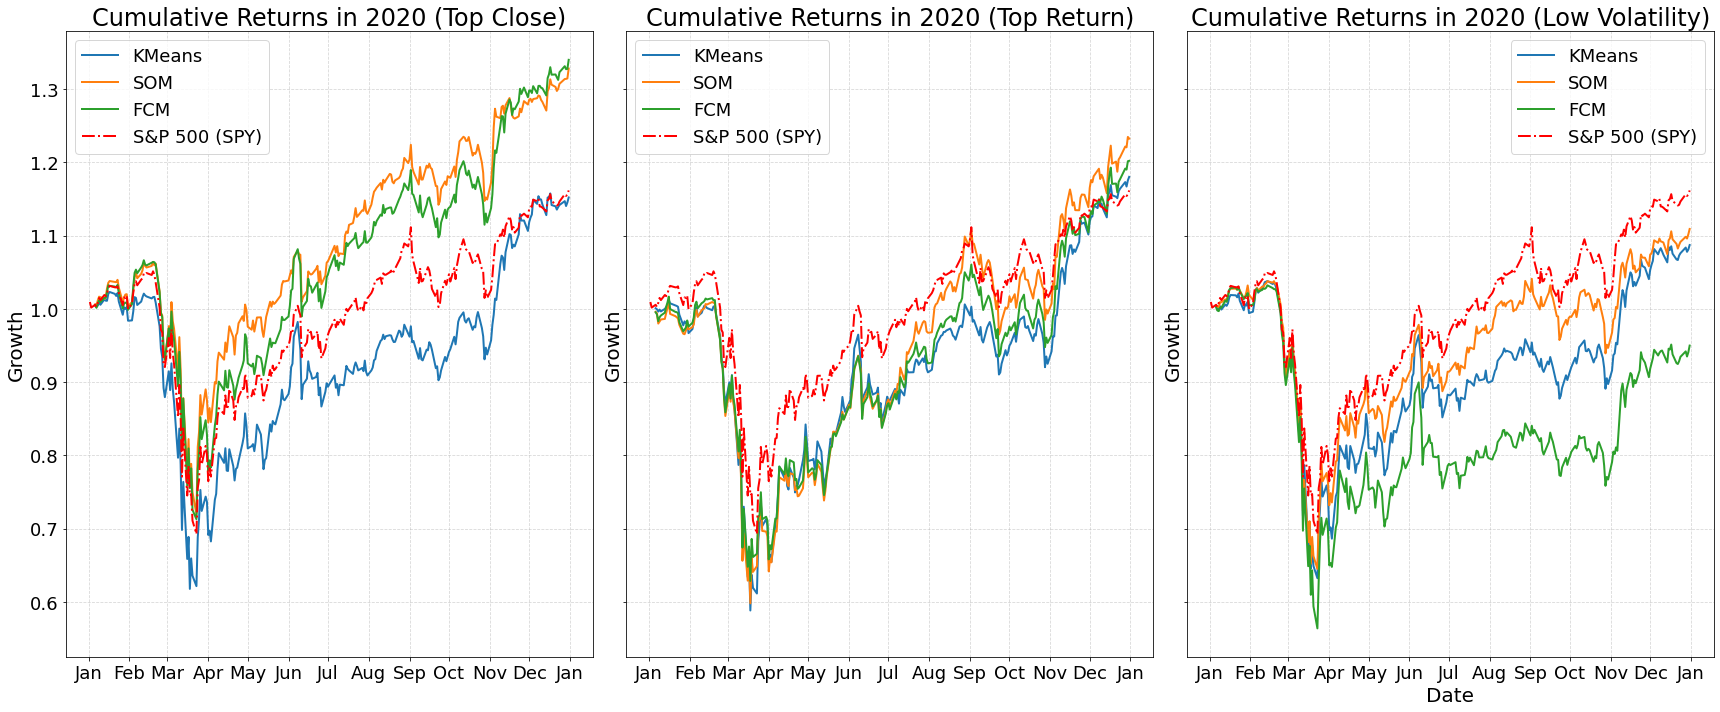

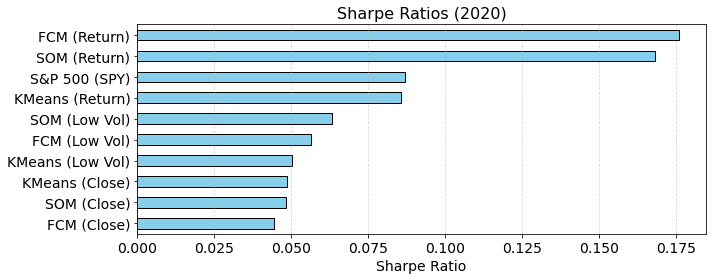

In [37]:
# Filter abnormal returns
df_2020 = df_2020.copy()
df_2020['Return'] = df_2020.groupby('Ticker')['Close'].pct_change()
df_2020 = df_2020.dropna(subset=['Return'])

max_abs_returns = df_2020.groupby('Ticker')['Return'].apply(lambda x: x.abs().max())
tickers_to_exclude = max_abs_returns[max_abs_returns > 1.0].index.tolist()
print("Tickers removed due to extreme daily returns:", tickers_to_exclude)

df_2020_clean = df_2020[~df_2020['Ticker'].isin(tickers_to_exclude)]

# Stress test function
def stress_test_portfolio(df_year, tickers, label):
    returns = df_year.copy()
    returns['Return'] = returns.groupby('Ticker')['Close'].pct_change()
    returns = returns.dropna(subset=['Return'])

    returns_wide = returns.pivot(index='Date', columns='Ticker', values='Return')

    first_date = returns_wide.index.min()
    valid_tickers = [ticker for ticker in tickers if ticker in returns_wide.columns and not pd.isna(returns_wide.loc[first_date, ticker])]

    missing = set(tickers) - set(valid_tickers)
    if missing:
        print(f"{label}: {len(missing)} tickers missing: {missing}")

    returns_wide = returns_wide[valid_tickers].dropna()

    weights = np.ones(len(valid_tickers)) / len(valid_tickers)
    portfolio_returns = returns_wide.dot(weights)
    cumulative_returns = (1 + portfolio_returns).cumprod()

    return portfolio_returns.rename(label), cumulative_returns.rename(label)

# Run stress test 
portfolios = {
    'KMeans (Close)': portfolio_kmeans_close,
    'SOM (Close)': portfolio_som_close,
    'FCM (Close)': portfolio_fcm_close,
    'KMeans (Return)': portfolio_kmeans_return,
    'SOM (Return)': portfolio_som_return,
    'FCM (Return)': portfolio_fcm_return,
    'KMeans (Low Vol)': portfolio_kmeans_vol,
    'SOM (Low Vol)': portfolio_som_vol,
    'FCM (Low Vol)': portfolio_fcm_vol
}

returns_2020 = {}
stress_2020 = {}

for name, tickers in portfolios.items():
    cleaned_tickers = [t for t in tickers if t not in tickers_to_exclude]
    ret, cum = stress_test_portfolio(df_2020_clean, cleaned_tickers, name)
    returns_2020[name] = ret
    stress_2020[name] = cum

# SPY Data
spy_2020 = main_df[(main_df['Ticker'] == 'SPY') & (main_df['Date'].dt.year == 2020)].copy()
spy_2020 = spy_2020.sort_values('Date')
spy_2020 = spy_2020.dropna(subset=['Return'])

spy_2020['Cumulative'] = (1 + spy_2020['Return']).cumprod()
spy_2020_cum = spy_2020.set_index('Date')['Cumulative']
spy_2020_ret = spy_2020.set_index('Date')['Return']

returns_2020['S&P 500 (SPY)'] = spy_2020_ret
stress_2020['S&P 500 (SPY)'] = spy_2020_cum

grouped_2020 = {
    'Top Close': {
        'KMeans': stress_2020['KMeans (Close)'],
        'SOM': stress_2020['SOM (Close)'],
        'FCM': stress_2020['FCM (Close)']
    },
    'Top Return': {
        'KMeans': stress_2020['KMeans (Return)'],
        'SOM': stress_2020['SOM (Return)'],
        'FCM': stress_2020['FCM (Return)']
    },
    'Low Volatility': {
        'KMeans': stress_2020['KMeans (Low Vol)'],
        'SOM': stress_2020['SOM (Low Vol)'],
        'FCM': stress_2020['FCM (Low Vol)']
    }
}

strategy_colors = {
    'KMeans': 'tab:blue',
    'SOM': 'tab:orange',
    'FCM': 'tab:green'
}

# Cumulative Returns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 10), sharex=True, sharey=True)

for ax, (strategy_name, cluster_returns) in zip(axes, grouped_2020.items()):
    for cluster_name, series in cluster_returns.items():
        ax.plot(series.index, series.values,
                label=cluster_name,
                color=strategy_colors[cluster_name],
                linewidth=2)

    ax.plot(spy_2020_cum.index, spy_2020_cum.values,
            label='S&P 500 (SPY)', color='red', linestyle='-.', linewidth=2)

    ax.set_title(f'Cumulative Returns in 2020 ({strategy_name})', fontsize=24)
    ax.set_ylabel('Growth', fontsize=20)
    ax.legend(fontsize=18)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

axes[-1].set_xlabel('Date', fontsize=20)
plt.tight_layout()
plt.savefig("2020Results.png", dpi=300, bbox_inches='tight')
plt.show()

# Sharpe Ratio
plt.figure(figsize=(10, 4))
sharpe_df['Sharpe Ratio'].plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Sharpe Ratios (2020)', fontsize=16)
plt.xlabel('Sharpe Ratio', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("2020ResultsSharpe.png", dpi=300, bbox_inches='tight')
plt.show()
sharpe_df_2020 = sharpe_df.copy()

Tickers removed due to extreme daily returns: []


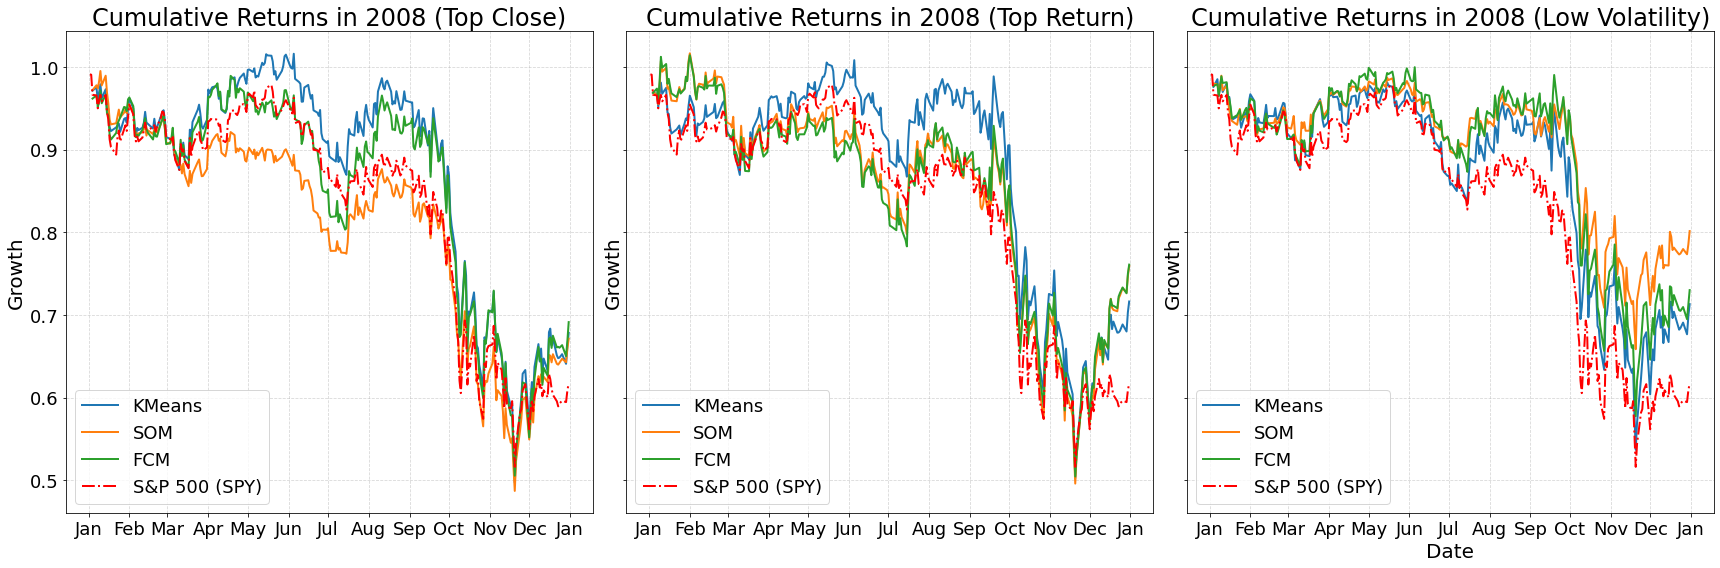

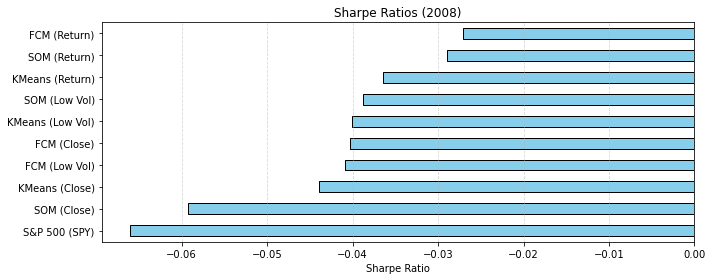

In [38]:
# Filter abnormal returns
df_2008 = df_2008.copy()
df_2008['Return'] = df_2008.groupby('Ticker')['Close'].pct_change()
df_2008 = df_2008.dropna(subset=['Return'])

max_abs_returns = df_2008.groupby('Ticker')['Return'].apply(lambda x: x.abs().max())
tickers_to_exclude = max_abs_returns[max_abs_returns > 1.0].index.tolist()
print("Tickers removed due to extreme daily returns:", tickers_to_exclude)

df_2008_clean = df_2008[~df_2008['Ticker'].isin(tickers_to_exclude)]

# Stress test function
def stress_test_portfolio(df_year, tickers, label):
    returns = df_year.copy()
    returns['Return'] = returns.groupby('Ticker')['Close'].pct_change()
    returns = returns.dropna(subset=['Return'])

    returns_wide = returns.pivot(index='Date', columns='Ticker', values='Return')

    first_date = returns_wide.index.min()
    valid_tickers = [ticker for ticker in tickers if ticker in returns_wide.columns and not pd.isna(returns_wide.loc[first_date, ticker])]

    missing = set(tickers) - set(valid_tickers)
    if missing:
        print(f"{label}: {len(missing)} tickers missing: {missing}")

    returns_wide = returns_wide[valid_tickers].dropna()

    weights = np.ones(len(valid_tickers)) / len(valid_tickers)
    portfolio_returns = returns_wide.dot(weights)
    cumulative_returns = (1 + portfolio_returns).cumprod()

    return portfolio_returns.rename(label), cumulative_returns.rename(label)

# Run stress test 
portfolios = {
    'KMeans (Close)': portfolio_kmeans_close,
    'SOM (Close)': portfolio_som_close,
    'FCM (Close)': portfolio_fcm_close,
    'KMeans (Return)': portfolio_kmeans_return,
    'SOM (Return)': portfolio_som_return,
    'FCM (Return)': portfolio_fcm_return,
    'KMeans (Low Vol)': portfolio_kmeans_vol,
    'SOM (Low Vol)': portfolio_som_vol,
    'FCM (Low Vol)': portfolio_fcm_vol
}

returns_2008 = {}
stress_2008 = {}

for name, tickers in portfolios.items():
    cleaned_tickers = [t for t in tickers if t not in tickers_to_exclude]
    ret, cum = stress_test_portfolio(df_2008_clean, cleaned_tickers, name)
    returns_2008[name] = ret
    stress_2008[name] = cum

# SPY Data
spy_2008 = main_df[(main_df['Ticker'] == 'SPY') & (main_df['Date'].dt.year == 2008)].copy()
spy_2008 = spy_2008.sort_values('Date')
spy_2008 = spy_2008.dropna(subset=['Return'])

spy_2008['Cumulative'] = (1 + spy_2008['Return']).cumprod()
spy_2008_cum = spy_2008.set_index('Date')['Cumulative']
spy_2008_ret = spy_2008.set_index('Date')['Return']

returns_2008['S&P 500 (SPY)'] = spy_2008_ret
stress_2008['S&P 500 (SPY)'] = spy_2008_cum

grouped_2008 = {
    'Top Close': {
        'KMeans': stress_2008['KMeans (Close)'],
        'SOM': stress_2008['SOM (Close)'],
        'FCM': stress_2008['FCM (Close)']
    },
    'Top Return': {
        'KMeans': stress_2008['KMeans (Return)'],
        'SOM': stress_2008['SOM (Return)'],
        'FCM': stress_2008['FCM (Return)']
    },
    'Low Volatility': {
        'KMeans': stress_2008['KMeans (Low Vol)'],
        'SOM': stress_2008['SOM (Low Vol)'],
        'FCM': stress_2008['FCM (Low Vol)']
    }
}

# Plotting
strategy_colors = {
    'KMeans': 'tab:blue',
    'SOM': 'tab:orange',
    'FCM': 'tab:green'
}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8), sharex=True, sharey=True)

for ax, (strategy_name, cluster_returns) in zip(axes, grouped_2008.items()):
    for cluster_name, series in cluster_returns.items():
        ax.plot(series.index, series.values,
                label=cluster_name,
                color=strategy_colors[cluster_name],
                linewidth=2)

    ax.plot(spy_2008_cum.index, spy_2008_cum.values,
            label='S&P 500 (SPY)', color='red', linestyle='-.', linewidth=2)

    ax.set_title(f'Cumulative Returns in 2008 ({strategy_name})', fontsize=24)
    ax.set_ylabel('Growth', fontsize=20)
    ax.legend(fontsize=18)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

axes[-1].set_xlabel('Date', fontsize=20)
plt.tight_layout()
plt.savefig("2008Results.png", dpi=300, bbox_inches='tight')
plt.show()

# Compute Sharpe Ratios 
treasury_2008 = pd.read_csv("daily-treasury-rates2008.csv")
treasury_2008['Date'] = pd.to_datetime(treasury_2008['Date'])
treasury_2008 = treasury_2008.set_index('Date').sort_index()
treasury_2008_daily_rf = treasury_2008['10 Yr'].dropna() / 100 / 252
avg_daily_rf_2008 = treasury_2008_daily_rf.mean()
sharpe_ratios = {}
for name, daily_returns in returns_2008.items():
    aligned_rf = treasury_2008_daily_rf.reindex(daily_returns.index).fillna(method='ffill')
    excess_returns = daily_returns - aligned_rf
    sharpe = excess_returns.mean() / excess_returns.std()
    sharpe_ratios[name] = sharpe
sharpe_df = pd.DataFrame.from_dict(sharpe_ratios, orient='index', columns=['Sharpe Ratio'])
sharpe_df = sharpe_df.sort_values(by='Sharpe Ratio')

plt.figure(figsize=(10, 4))
sharpe_df['Sharpe Ratio'].plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Sharpe Ratios (2008)')
plt.xlabel('Sharpe Ratio')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("2008ResultsSharpe.png", dpi=300, bbox_inches='tight')
plt.show()
sharpe_df_2008 = sharpe_df.copy()

Plot for Final Poster

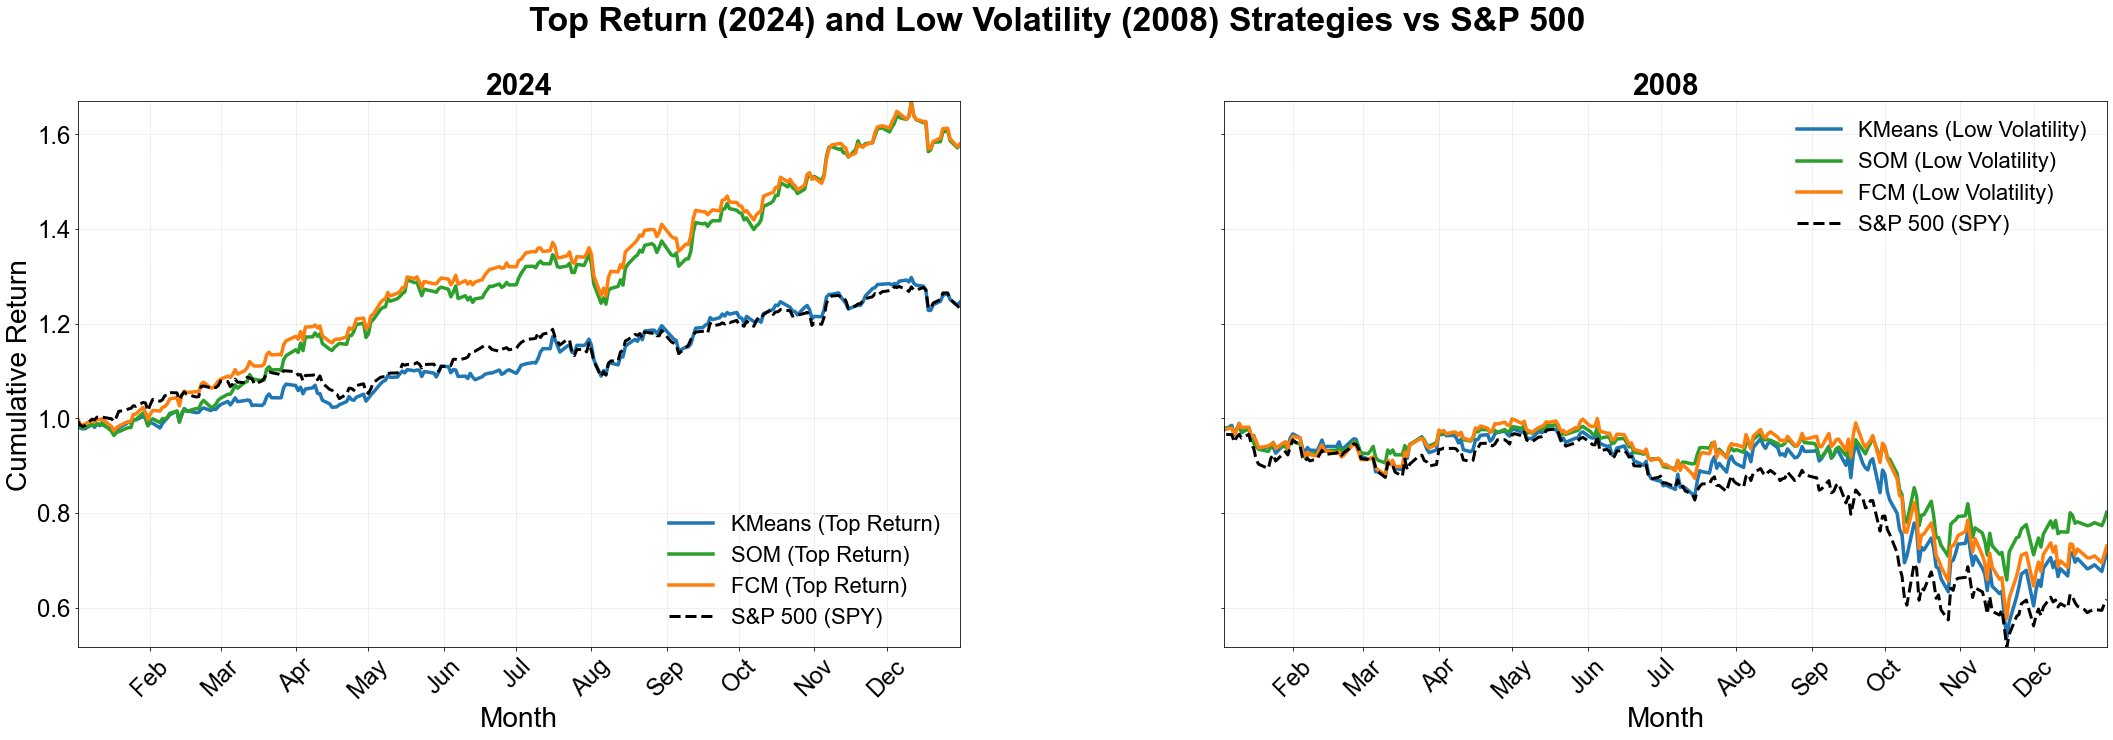

In [39]:
grouped_data = {
    2024: grouped_returns,     # This holds strategies like 'Top Return', 'Low Volatility', etc.
    2008: grouped_2008,
}
spy_data = {
    2024: spy_2024_cum,
    2008: spy_2008_cum,
}
strategy_colors = {
    'KMeans': 'tab:blue',
    'SOM': 'tab:green',
    'FCM': 'tab:orange',
}

# Plotting setup
plt.rcParams.update({'font.size': 28, 'font.family': 'Arial'})
fig, axs = plt.subplots(1, 2, figsize=(30, 10), sharey=True)
years = [2024, 2008]
strategies = {
    2024: 'Top Return',
    2008: 'Low Volatility'
}

# Y-axis range calculation
all_values = []
for year in years:
    strat = strategies[year]
    for algo in ['KMeans', 'SOM', 'FCM']:
        all_values.extend(grouped_data[year][strat][algo].values)
    all_values.extend(spy_data[year].values)
ymin, ymax = min(all_values), max(all_values)

# Plot each subplot
for i, year in enumerate(years):
    ax = axs[i]
    strat = strategies[year]
    for algo in ['KMeans', 'SOM', 'FCM']:
        series = grouped_data[year][strat][algo]
        ax.plot(series.index, series.values,
                label=f"{algo} ({strat})",
                color=strategy_colors[algo], linewidth=3.5)

    ax.plot(spy_data[year].index, spy_data[year].values,
            label='S&P 500 (SPY)', color='black', linestyle='--', linewidth=3)

    ax.set_title(f"{year}", fontsize=30, weight='bold')
    ax.set_xlabel("Month", fontsize=28)
    if i == 0:
        ax.set_ylabel("Cumulative Return", fontsize=28)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.tick_params(axis='x', rotation=45, labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    ax.set_xlim(series.index.min(), series.index.max())
    ax.set_ylim(ymin, ymax)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    ax.legend(loc='lower right' if year == 2024 else 'upper right', fontsize=22, frameon=False)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.suptitle("Top Return (2024) and Low Volatility (2008) Strategies vs S&P 500", fontsize=34, weight='bold', y=1.05)
plt.savefig("2024vs2008.png", dpi=300, bbox_inches='tight')
plt.show()

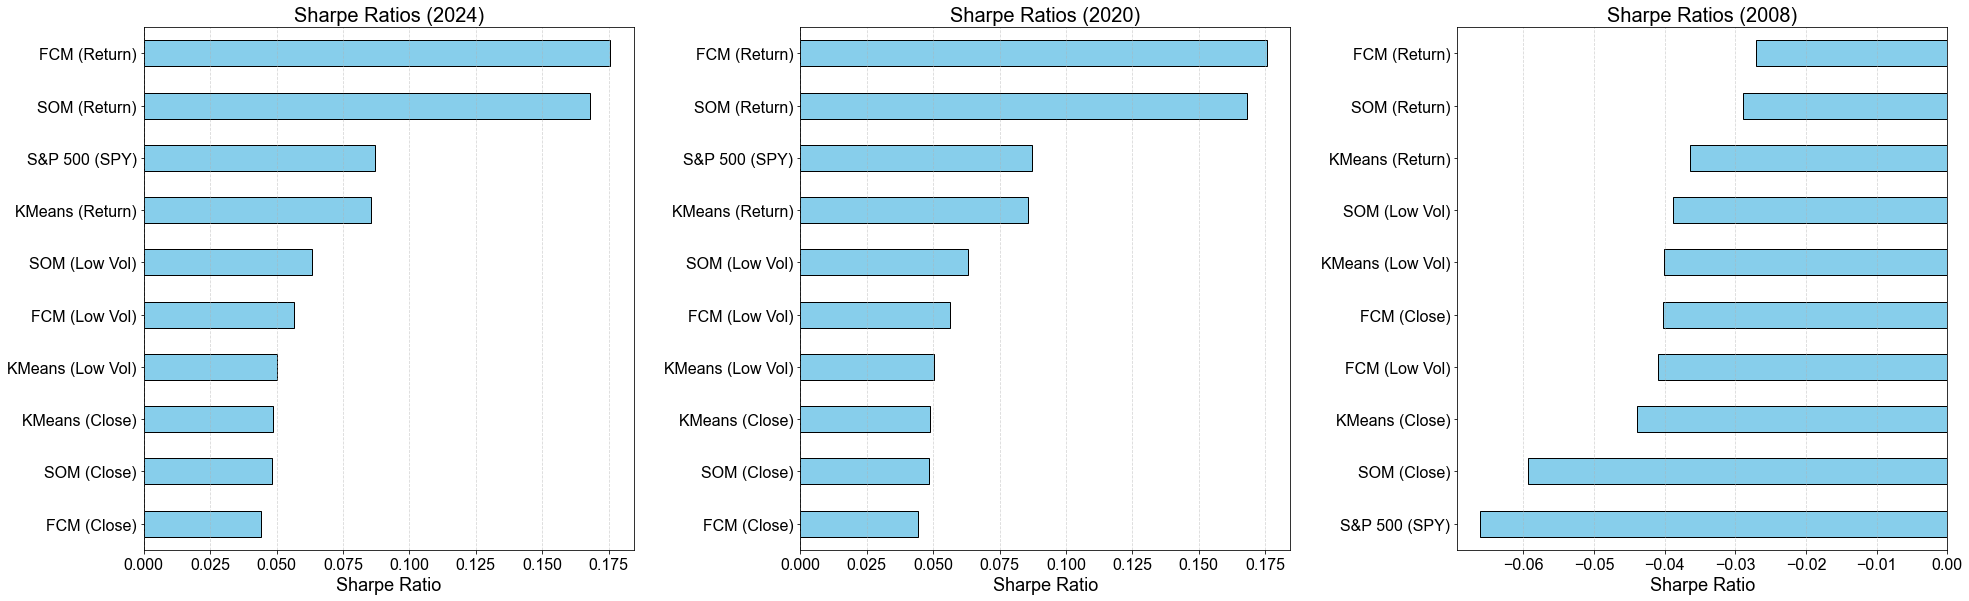

In [40]:
# Sort each for consistent display
sharpe_df_2024 = sharpe_df_2024.sort_values(by='Sharpe Ratio')
sharpe_df_2020 = sharpe_df_2020.sort_values(by='Sharpe Ratio')
sharpe_df_2008 = sharpe_df_2008.sort_values(by='Sharpe Ratio')

# Plot all side-by-side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28, 9), sharex=False)

# 2024
sharpe_df_2024['Sharpe Ratio'].plot(kind='barh', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Sharpe Ratios (2024)', fontsize=20)
axes[0].set_xlabel('Sharpe Ratio', fontsize=18)
axes[0].tick_params(labelsize=16)
axes[0].axvline(x=0, color='gray', linestyle='--', linewidth=1)
axes[0].grid(axis='x', linestyle='--', alpha=0.5)

# 2020
sharpe_df_2020['Sharpe Ratio'].plot(kind='barh', ax=axes[1], color='skyblue', edgecolor='black')
axes[1].set_title('Sharpe Ratios (2020)', fontsize=20)
axes[1].set_xlabel('Sharpe Ratio', fontsize=18)
axes[1].tick_params(labelsize=16)
axes[1].axvline(x=0, color='gray', linestyle='--', linewidth=1)
axes[1].grid(axis='x', linestyle='--', alpha=0.5)

# 2008
sharpe_df_2008['Sharpe Ratio'].plot(kind='barh', ax=axes[2], color='skyblue', edgecolor='black')
axes[2].set_title('Sharpe Ratios (2008)', fontsize=20)
axes[2].set_xlabel('Sharpe Ratio', fontsize=18)
axes[2].tick_params(labelsize=16)
axes[2].axvline(x=0, color='gray', linestyle='--', linewidth=1)
axes[2].grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("sharpeScoresCombined.png", dpi=300)
plt.show()

# Debugging 

Mean daily returns in 2008 for FCM (Return):
Ticker
CDE     -0.003976
GOOGL   -0.002578
AMZN    -0.001645
LLY     -0.000696
IMAX    -0.000620
AXS     -0.000507
JPM      0.000246
WELL     0.000349
WMT      0.000930
DAL      0.001942
Name: Return, dtype: float64


C:\Users\Bradford\AppData\Local\Temp\ipykernel_40360\2305466065.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fcm_2008['Cumulative'] = df_fcm_2008.groupby('Ticker')['Return'].apply(lambda x: (1 + x).cumprod())
C:\Users\Bradford\AppData\Local\Temp\ipykernel_40360\2305466065.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


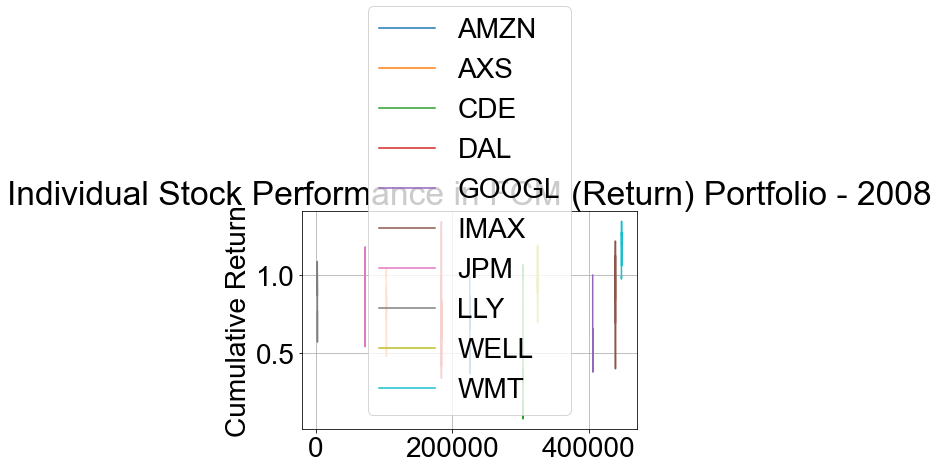

In [41]:
# Check average return in 2008 for each ticker in the FCM Return portfolio
df_fcm_2008 = df_2008[df_2008['Ticker'].isin(portfolio_fcm_return)]
mean_returns = df_fcm_2008.groupby('Ticker')['Return'].mean().sort_values()
print("Mean daily returns in 2008 for FCM (Return):")
print(mean_returns)

# Plot cumulative returns for those tickers
df_fcm_2008['Cumulative'] = df_fcm_2008.groupby('Ticker')['Return'].apply(lambda x: (1 + x).cumprod())
df_fcm_2008.groupby('Ticker')['Cumulative'].plot(legend=True)
plt.title("Individual Stock Performance in FCM (Return) Portfolio - 2008")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
# Dictionary of portfolios for printing
portfolios = {
    'KMeans - Top Close': portfolio_kmeans_close,
    'SOM - Top Close': portfolio_som_close,
    'FCM - Top Close': portfolio_fcm_close,
    
    'KMeans - Top Return': portfolio_kmeans_return,
    'SOM - Top Return': portfolio_som_return,
    'FCM - Top Return': portfolio_fcm_return,
    
    'KMeans - Low Volatility': portfolio_kmeans_vol,
    'SOM - Low Volatility': portfolio_som_vol,
    'FCM - Low Volatility': portfolio_fcm_vol,
}

# Print each portfolio
for name, tickers in portfolios.items():
    print(f"\n📌 {name} ({len(tickers)} stocks):")
    print(sorted(tickers))



📌 KMeans - Top Close (36 stocks):
['AAPL', 'AFL', 'ALL', 'AMZN', 'AOS', 'AXS', 'BLK', 'BRK.B', 'CI', 'CLH', 'DE', 'GE', 'GOOGL', 'JNJ', 'JPM', 'KWR', 'LAMR', 'LLY', 'MAA', 'MCD', 'MSFT', 'NKE', 'NRP', 'ON', 'REX', 'SHW', 'SIGI', 'SLAB', 'SPG', 'STT', 'SYY', 'UNH', 'WELL', 'WSM', 'X', 'XOM']

📌 SOM - Top Close (10 stocks):
['ASA', 'BLK', 'BRK.B', 'CI', 'DE', 'LLY', 'MCD', 'MSFT', 'SHW', 'UNH']

📌 FCM - Top Close (10 stocks):
['AMZN', 'BLK', 'BRK.B', 'DE', 'KWR', 'LLY', 'MSFT', 'SHW', 'SPG', 'UNH']

📌 KMeans - Top Return (36 stocks):
['AAPL', 'AFL', 'ALL', 'AMZN', 'AOS', 'ASA', 'AXS', 'BAC', 'BLK', 'BRC', 'BRK.B', 'CDE', 'CLH', 'CSIQ', 'DAL', 'FUN', 'GCO', 'GOOGL', 'HMC', 'IMAX', 'JPM', 'LAMR', 'LLY', 'MCD', 'NHI', 'NYT', 'PSMT', 'RGLD', 'SHW', 'SIGI', 'SLAB', 'SPG', 'STT', 'WELL', 'WMT', 'X']

📌 SOM - Top Return (10 stocks):
['AMZN', 'ASA', 'AXS', 'CDE', 'DAL', 'GOOGL', 'IMAX', 'JPM', 'WELL', 'WMT']

📌 FCM - Top Return (10 stocks):
['AMZN', 'AXS', 'CDE', 'DAL', 'GOOGL', 'IMAX', 'JPM', 

FCM (Return) Portfolio Tickers:
['IMAX', 'WMT', 'AXS', 'CDE', 'JPM', 'GOOGL', 'DAL', 'AMZN', 'WELL', 'LLY']
Valid return count in 2024:
Ticker
AMZN     252
AXS      252
CDE      252
DAL      252
GOOGL    252
IMAX     252
JPM      252
LLY      252
WELL     252
WMT      251
Name: Return, dtype: int64
First available return date per ticker:
Ticker
AMZN    2024-01-02
AXS     2024-01-02
CDE     2024-01-02
DAL     2024-01-02
GOOGL   2024-01-02
IMAX    2024-01-02
JPM     2024-01-02
LLY     2024-01-02
WELL    2024-01-02
WMT     2024-01-02
Name: Date, dtype: datetime64[ns]


C:\Users\Bradford\AppData\Local\Temp\ipykernel_40360\3561097232.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\Bradford\AppData\Local\Temp\ipykernel_40360\3561097232.py:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
C:\Users\Bradford\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


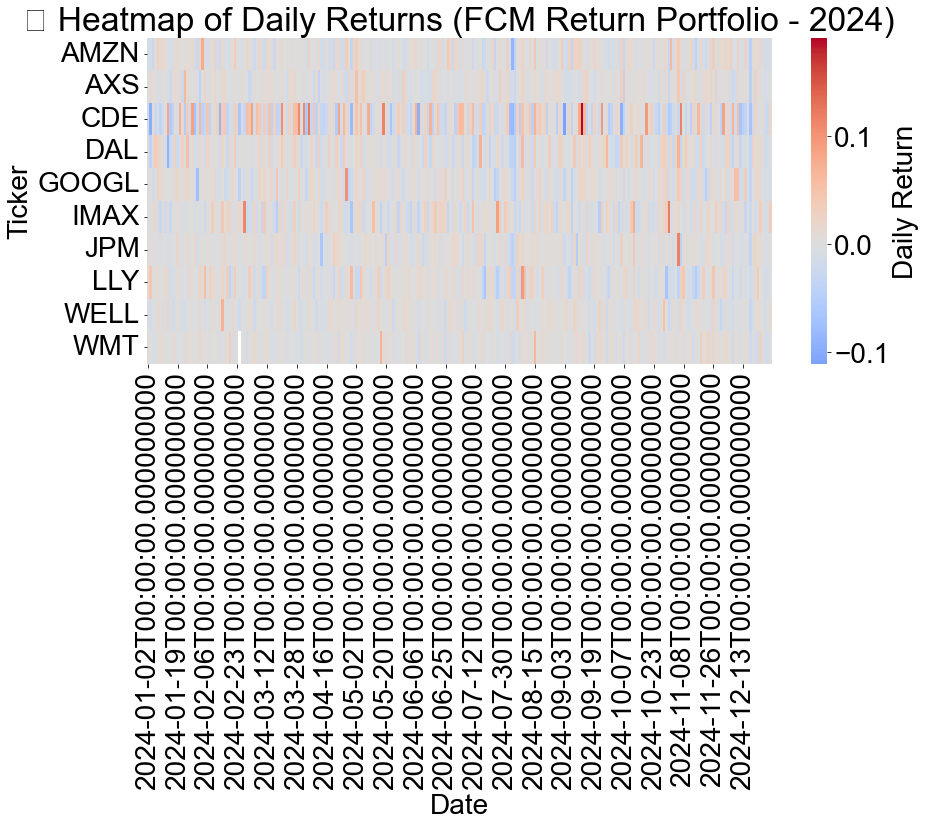

In [43]:
print("FCM (Return) Portfolio Tickers:")
print(portfolio_fcm_return)

# Return count per ticker (2024 only)
fcm_returns = df_2024_clusters[df_2024_clusters['Ticker'].isin(portfolio_fcm_return)]

coverage = (
    fcm_returns.groupby('Ticker')['Return']
    .apply(lambda x: x.notna().sum())
    .sort_values(ascending=False)
)

print("Valid return count in 2024:")
print(coverage)

# First available date per ticker
first_dates = (
    fcm_returns.groupby('Ticker')['Date']
    .min()
    .sort_values()
)

print("First available return date per ticker:")
print(first_dates)

# Return heatmap across 2024
pivot_returns = (
    fcm_returns.pivot(index='Date', columns='Ticker', values='Return')
)

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_returns.T, cmap="coolwarm", center=0, cbar_kws={'label': 'Daily Return'})
plt.title("📊 Heatmap of Daily Returns (FCM Return Portfolio - 2024)")
plt.xlabel("Date")
plt.ylabel("Ticker")
plt.tight_layout()
plt.show()


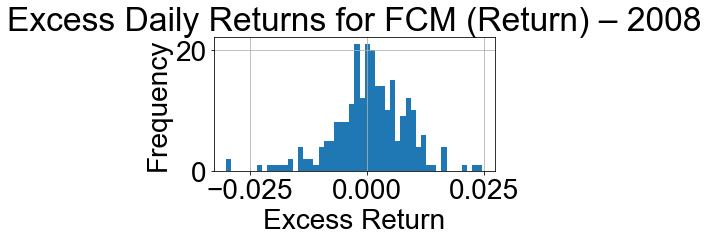

In [44]:
excess.hist(bins=50, figsize=(6, 4))
plt.title("Excess Daily Returns for FCM (Return) – 2008")
plt.xlabel("Excess Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

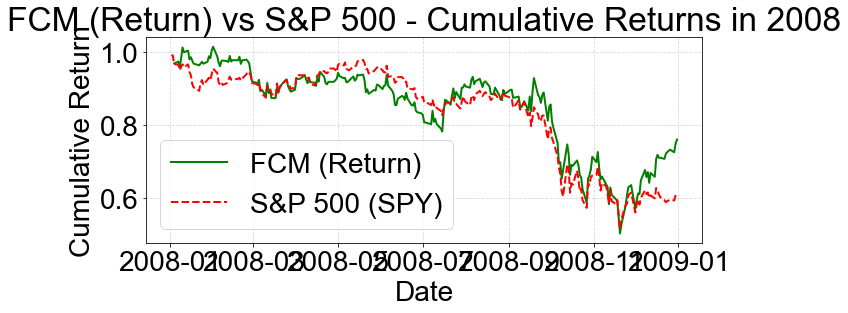

FCM (Return) total return: -23.91%
S&P 500 total return: -38.28%


In [45]:
# Compute cumulative returns
fcmp_2008 = returns_2008['FCM (Return)']
spy_2008 = returns_2008['S&P 500 (SPY)']
cum_fcmp_2008 = (1 + fcmp_2008).cumprod()
cum_spy_2008 = (1 + spy_2008).cumprod()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(cum_fcmp_2008.index, cum_fcmp_2008.values, label='FCM (Return)', color='green', linewidth=2)
plt.plot(cum_spy_2008.index, cum_spy_2008.values, label='S&P 500 (SPY)', color='red', linestyle='--', linewidth=2)
plt.title("FCM (Return) vs S&P 500 - Cumulative Returns in 2008")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Print total return comparison
print(f"FCM (Return) total return: {cum_fcmp_2008.iloc[-1] - 1:.2%}")
print(f"S&P 500 total return: {cum_spy_2008.iloc[-1] - 1:.2%}")


In [46]:
nee_2020 = df_2020[df_2020['Ticker'] == 'NEE'].copy()
nee_2020 = nee_2020.sort_values('Date')

nee_2020['Abs Return'] = nee_2020['Return'].abs()
largest_drop = nee_2020.loc[nee_2020['Abs Return'].idxmax()]

print("Largest daily move for NEE in 2020:")
print(largest_drop[['Date', 'Close', 'Return']])
print("Suspicious rows (Close <= 1 or Return <= -0.5):")
print(nee_2020[(nee_2020['Close'] <= 1) | (nee_2020['Return'] <= -0.5)])

Largest daily move for NEE in 2020:
Date      2020-10-28 00:00:00
Close                   74.46
Return              -0.753973
Name: 495078, dtype: object
Suspicious rows (Close <= 1 or Return <= -0.5):
             Date   Open   High    Low  Close  5. volume Ticker     Sector  \
495078 2020-10-28  74.74  76.05  74.29  74.46    7508864    NEE  Utilities   

       MarketCap    Return  LogReturn     MA20  Volatility_20d  \
495078     Large -0.753973  -0.017572  275.574        0.169001   

        High_Low_Range  Abs Return  
495078        0.023548    0.753973  


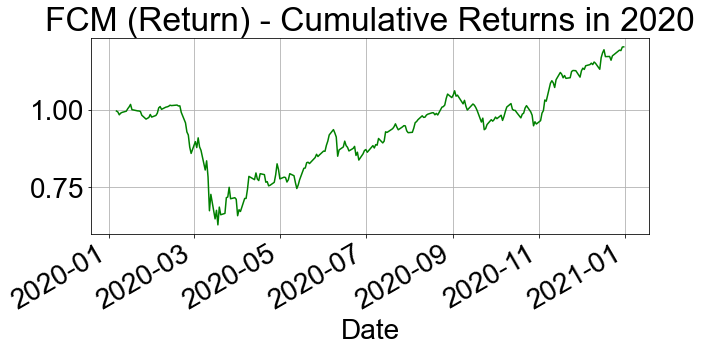

Tickers in FCM (Return):
['IMAX', 'WMT', 'AXS', 'CDE', 'JPM', 'GOOGL', 'DAL', 'AMZN', 'WELL', 'LLY']


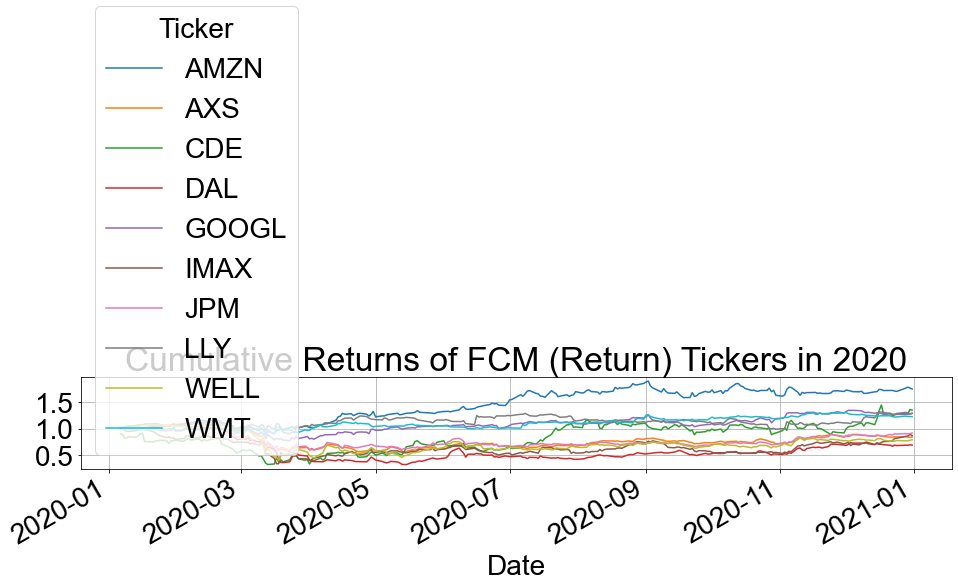


 FCM (Return) Summary (2020):
Total Cumulative Return: 20.20%
Mean Daily Return: 0.00105
Std Dev Daily Return: 0.02488
Sharpe Ratio: -0.0271


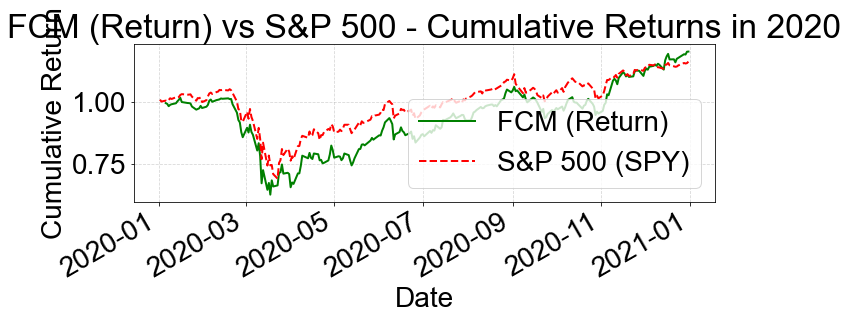

In [47]:
# Plot FCM (Return) Cumulative Returns
stress_2020['FCM (Return)'].plot(
    title='FCM (Return) - Cumulative Returns in 2020',
    figsize=(10, 4),
    color='green'
)
plt.grid(True)
plt.show()

print("Tickers in FCM (Return):")
print(portfolio_fcm_return)

returns_subset = df_2020[df_2020['Ticker'].isin(portfolio_fcm_return)].copy()
returns_subset['Return'] = returns_subset.groupby('Ticker')['Close'].pct_change()
returns_subset = returns_subset.dropna(subset=['Return'])
pivot_returns = returns_subset.pivot(index='Date', columns='Ticker', values='Return')
pivot_returns = pivot_returns.dropna()

cumulative_returns = (1 + pivot_returns).cumprod()

# Plot each ticker’s cumulative return
cumulative_returns.plot(
    figsize=(14, 6),
    title='Cumulative Returns of FCM (Return) Tickers in 2020'
)
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary Statistics
fcm_return = returns_2020['FCM (Return)']
fcm_cum_return = stress_2020['FCM (Return)']

print("\n FCM (Return) Summary (2020):")
print(f"Total Cumulative Return: {fcm_cum_return.iloc[-1] - 1:.2%}")
print(f"Mean Daily Return: {fcm_return.mean():.5f}")
print(f"Std Dev Daily Return: {fcm_return.std():.5f}")
print(f"Sharpe Ratio: {sharpe_ratios['FCM (Return)']:.4f}")

# Compare FCM (Return) vs S&P 500
plt.figure(figsize=(10, 5))
stress_2020['FCM (Return)'].plot(label='FCM (Return)', linewidth=2, color='green')
stress_2020['S&P 500 (SPY)'].plot(label='S&P 500 (SPY)', linestyle='--', linewidth=2, color='red')
plt.title('FCM (Return) vs S&P 500 - Cumulative Returns in 2020')
plt.ylabel('Cumulative Return')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


STRA Suspicious 10-Day Drops:
            Date  Close  10DayDrop
26203 2024-08-01  96.86  -0.115353
26204 2024-08-02  94.84  -0.132296
26205 2024-08-05  94.26  -0.135784
26206 2024-08-06  93.35  -0.132354
26207 2024-08-07  91.35  -0.156510
26208 2024-08-08  94.38  -0.147964
26209 2024-08-09  94.64  -0.149303
26210 2024-08-12  92.50  -0.193408
26211 2024-08-13  94.34  -0.202401
26212 2024-08-14  94.36  -0.207458
26213 2024-08-15  95.39  -0.188792
26214 2024-08-16  95.76  -0.187580
26215 2024-08-19  96.48  -0.183342
26216 2024-08-20  96.17  -0.191781
26217 2024-09-19  94.80  -0.198986
26218 2024-09-20  93.23  -0.210317
26219 2024-09-23  92.48  -0.232085
26220 2024-09-24  92.18  -0.224401
26221 2024-09-25  91.59  -0.241993
26222 2024-09-26  91.37  -0.133112
Removed 29 rows for STRA based on 10-day drop threshold


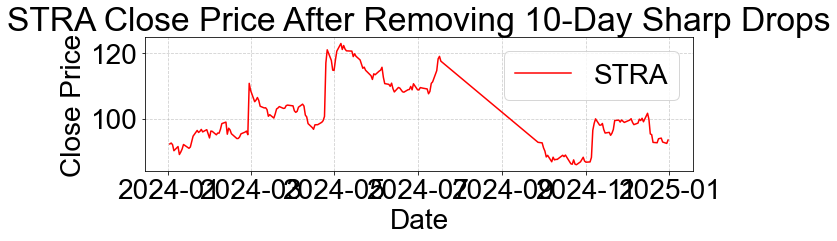

In [48]:
ticker = "STRA"
threshold_10day = -0.10  # Cumulative drop of -10% over 10 days

# Filter and compute daily returns
stra = df_2024_clusters[df_2024_clusters['Ticker'] == ticker].sort_values('Date').copy()
stra['DailyReturn'] = stra['Close'].pct_change()

# Compute rolling 10-day return
stra['10DayDrop'] = stra['Close'].pct_change(periods=20)

# Flag rows with sharp 10-day drop
suspicious_periods = stra[stra['10DayDrop'] < threshold_10day]

print("STRA Suspicious 10-Day Drops:")
print(suspicious_periods[['Date', 'Close', '10DayDrop']])

# Get full 10-day windows to remove
drop_indices = suspicious_periods.index
dates_to_drop = set()
for idx in drop_indices:
    dates_to_drop.update(stra.loc[max(0, idx-9):idx, 'Date'])

# Drop those rows from the main DataFrame
df_2024_clusters = df_2024_clusters[
    ~((df_2024_clusters['Ticker'] == ticker) & (df_2024_clusters['Date'].isin(dates_to_drop)))
]

print(f"Removed {len(dates_to_drop)} rows for STRA based on 10-day drop threshold")

# Plot cleaned STRA
stra_cleaned = df_2024_clusters[df_2024_clusters['Ticker'] == ticker]
plt.figure(figsize=(10, 4))
plt.plot(stra_cleaned['Date'], stra_cleaned['Close'], color='red', label='STRA')
plt.title('STRA Close Price After Removing 10-Day Sharp Drops')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
